# Analysis of Response Time to Pothole Repair Requests in Chicago

This project uses data from the City of Chicago and CMAP to compare pothole metrics (number of holes found per block, repair response time, etc.) against census data for each of the city's 77 community areas.  We set out to achieve the following:

1) Determine if correlations between census variables (median income, race, etc.) and pothole metrics (number of 311 service requests, average response time, number of potholes found per block) exist.  Does the DoT respond more quickly to more affluent areas?  What variables most influence the number of potholes found by the DoT per block?

2) Determine if there is a statistically significant difference between northern and southern community areas in repair response time or the number of potholes found per block. Perform k-means clustering to discover if census data can accurately predict a northern or southern community area.

3) Create regression model using machine learning to predict response time and number of potholes found per block given census data for a particular area.  This model could be used to granularize the city into census tracts or other smaller geographic areas and provide more localized estimates of pothole repair response time and frequency.

In [210]:
import json
import numpy as np
import pandas as pd
import datetime

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style(style='white')

#### Importing data from JSON 

Link to dataset: https://data.cityofchicago.org/Service-Requests/311-Service-Requests-Pot-Holes-Reported/7as2-ds3y

In [211]:
with open('data/311_requests.json', encoding='utf-8') as data_file:
    data = json.loads(data_file.read())

#Retrieve column headings from metadata JSON 
columnHeadings = []
for d in data['meta']['view']['columns']:
    if 'flags' not in d.keys():
        columnHeadings.append(d['name'])
columnHeadings = columnHeadings[0:len(columnHeadings) - 1]

#Gather data rows into list and removing unnecessary initial columns
rows = data['data']
dataset = []
for row in rows:
    new_row = row[8:len(row)-1]
    dataset.append(new_row)

#Convert to panda DataFrame
dfOriginal = pd.DataFrame(dataset)
dfOriginal.columns = columnHeadings

### Cleaning the dataset

In [212]:
df = dfOriginal.copy()

#Convert completion date from string to datetime object
cleanedCompletionDate = []
for date in df['COMPLETION DATE']:
    if date != None:
        cleanedCompletionDate.append(datetime.datetime.strptime(date, '%Y-%m-%dT%H:%M:%S'))
    else:
        cleanedCompletionDate.append(None)
df.insert(3, 'clean Completion Date', cleanedCompletionDate)

#Convert creation date from string to datetime object
cleanedCreationDate = []
for date in df['CREATION DATE']:
    if date != None:
        cleanedCreationDate.append(datetime.datetime.strptime(date, '%Y-%m-%dT%H:%M:%S'))
    else:
        cleanedCreationDate.append(None)
df.insert(1, 'clean Creation Date', cleanedCreationDate)

#Convert 'Number of Potholes Filled on Block' to integers and latitude, longitude, x & y coordinates to floats
df.insert(10, 'Num_Holes_Found', pd.to_numeric(df['NUMBER OF POTHOLES FILLED ON BLOCK'], errors = 'ignore', downcast = 'integer'))
df.insert(11, 'X Coordinate', pd.to_numeric(df['X COORDINATE']).fillna(''))
df.insert(12, 'Y Coordinate', pd.to_numeric(df['Y COORDINATE']).fillna(''))
df.insert(13, 'Latitude', pd.to_numeric(df['LATITUDE']).fillna(''))
df.insert(14, 'Longitude', pd.to_numeric(df['LONGITUDE']).fillna(''))

#Delete original columns containing uncleaned data
del df['CREATION DATE'], df['COMPLETION DATE'], df['NUMBER OF POTHOLES FILLED ON BLOCK'], df['X COORDINATE'], df['Y COORDINATE'], df['LATITUDE'], df['LONGITUDE']

df

,clean Creation Date,STATUS,clean Completion Date,SERVICE REQUEST NUMBER,TYPE OF SERVICE REQUEST,CURRENT ACTIVITY,MOST RECENT ACTION,Num_Holes_Found,X Coordinate,Y Coordinate,Latitude,Longitude,STREET ADDRESS,ZIP,Ward,Police District,Community Area,SSA
0,2011-01-01,Completed - Dup,2011-01-03,11-00002110,Pot Hole in Street,None,None,NaN,1.17386e+06,1.85451e+06,41.7561,-87.6385,7600 S PARNELL AVE,60620,17,6,69,None
1,2011-01-01,Completed - Dup,2011-01-03,11-00002209,Pot Hole in Street,None,None,NaN,1.15093e+06,1.85722e+06,41.764,-87.7225,7100 S PULASKI RD,60629,13,8,65,3
2,2011-01-01,Completed - Dup,2011-01-03,11-00002224,Pot Hole in Street,None,None,NaN,1.15996e+06,1.91589e+06,41.925,-87.6877,2400 W FULLERTON AVE,60647,1,14,22,None
3,2011-01-01,Completed - Dup,2011-01-03,11-00002247,Pot Hole in Street,None,None,NaN,1.17296e+06,1.83124e+06,41.6923,-87.6425,11100 S HALSTED ST,60628,34,22,75,45
4,2011-01-01,Completed - Dup,2011-01-03,11-00002276,Pot Hole in Street,None,None,NaN,1.1757e+06,1.89504e+06,41.8673,-87.6306,1200 S CLARK ST,60605,2,1,33,None
5,2011-01-01,Completed - Dup,2011-01-03,11-00002947,Pot Hole in Street,None,None,NaN,1.17533e+06,1.91646e+06,41.9262,-87.6313,2400 N NB OUTER LAKE SHORE DR,60614,43,23,7,None
6,2011-01-01,Completed - Dup,2011-01-03,11-00003041,Pot Hole in Street,None,None,NaN,1.16694e+06,1.91077e+06,41.9107,-87.6623,1600 N ELSTON AVE,60642,32,14,24,None
7,2011-01-01,Completed - Dup,2011-01-03,11-00003086,Pot Hole in Street,None,None,NaN,1.15093e+06,1.85722e+06,41.764,-87.7225,7100 S PULASKI RD,60629,13,8,65,3
8,2011-01-01,Completed - Dup,2011-01-03,11-00003439,Pot Hole in Street,None,None,NaN,1.16914e+06,1.92283e+06,41.9438,-87.654,3408 N CLARK ST,60657,44,19,6,17
9,2011-01-01,Completed,2011-01-03,11-00002021,Pot Hole in Street,Dispatch Crew,Pothole Patched,5.0,1.16695e+06,1.83906e+06,41.714,-87.6651,1642 W 99TH ST,60643,19,22,72,None


In [213]:
#Remove any data pertaining to Ward 0
df = df[df.Ward != '0']

In [214]:
#Examine the type of actions taken on all 311 service requests
df.groupby('MOST RECENT ACTION')['MOST RECENT ACTION'].count()

MOST RECENT ACTION
 No Problem Found                                                            5896
CDOT Alley Grading - Unimproved Transfer Outcome                               72
CDOT Alley Pot Hole Transfer Outcome                                         1672
CDOT Asphalt Top Off Restoration Transfer Outcome                              53
CDOT Electrical Operations Construction Complaints Transfer Outcome             9
CDOT Inspect Public Way Survey Transfer Outcome                               666
CDOT Pavement Buckle or Speed Hump Transfer Outcome                           171
CDOT Pavement Cave-In Survey Transfer Outcome                                3975
CDOT Street Cut Complaints Transfer Outcome                                   971
Complete Upon Arrival                                                        5342
Completed                                                                     999
Completed Upon Arrival                                                      125

### Data Exploration

To begin, we'll examine relationships in the pothole data set.  Later in the analysis, we will pull in census data to nderstand each community areas's median salary, percentage of land zoned as residential, etc. 

First, we'll look at two statements made by the City when introducing this dataset: 
    
    1) “Pothole repairs are generally completed within 7 days from the first report of a pothole to 311.”  
    2) “Weather conditions, particularly frigid temps and precipitation, influence how long a repair takes.” 

#### Average wait time for pothole repair 

First, let's test the City's statement that "Pothole repairs are generally completed within 7 days from the first report of a pothole to 311."

In [215]:
df = df.assign(timePassed = (df['clean Completion Date'] - df['clean Creation Date']).dt.days)

weekOrLess = df[df['timePassed'] <= 7].copy()

#Count by creation date to find all requests
pctWeekOrLess = weekOrLess['clean Creation Date'].count() * 100 / df['clean Creation Date'].count()
print('Pct holed filled in week or less:', '{:.2f}'.format(pctWeekOrLess), '%')

Pct holed filled in week or less: 49.05 %


More than 49% of all pothole requests are completed within 7 days.  How does the number of days that elapse between service request and completion vary depending on the community area (CA) in which the pothole is located?  This will be explored later in the analysis.

#### Average wait time for pothole repair by season

Let's see how response time varies by the season in which the request was created.

In [216]:
#Create seasons by clustering months
spring = [3, 4, 5]
summer = [6, 7, 8]
fall = [9, 10, 11]
winter = [12, 1, 2]

#Initialize season list
seasons = []

#Run through creation dates in dataframe and append correct season to list
for date in df['clean Creation Date']:
    if date.month in winter:
        seasons.append('winter')
    elif date.month in fall:
        seasons.append('fall')
    elif date.month in spring:
        seasons.append('spring')
    elif date.month in summer:
        seasons.append('summer')

#Add seasons as a column in dataframe
df = df.assign(season = seasons)

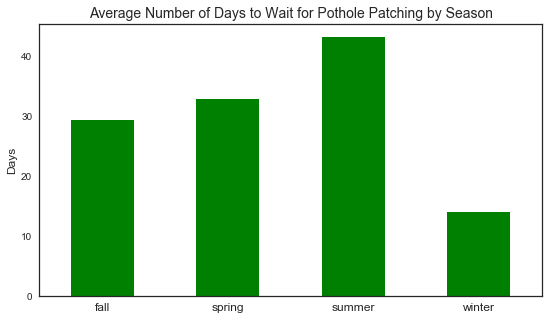

In [217]:
avgDaysBySeason = df.groupby('season')['timePassed'].mean()

fig = plt.figure(figsize=(9, 5))
avgDaysBySeason.plot(kind='bar', color = 'g')
plt.ylabel('Days', fontsize = 12);
plt.title('Average Number of Days to Wait for Pothole Patching by Season', fontsize=14);
ax = plt.gca()
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0, fontsize = 12);
plt.xlabel('');

In [218]:
avgDaysBySeason

season
fall      29.290866
spring    32.807026
summer    43.251978
winter    14.040487
Name: timePassed, dtype: float64

Interestingly, even though the City claims that frigid temperatures can delay pothole repairs, we find that summer results in the longest wait while winter has the shortest.  We could pull in weather data to see how temperature and precipitation specifically affect response time.  Did Chicago have unusually mild winters over the past six years?  Have the summers been too rainy to patch potholes?

Another point to consider is that pothole frequency generally increases in the winter due to the freeze/thaw cycle.  Let's look at the statistical significance of the difference in winter and summer reporting.

In [219]:
#First we'll check the Mann-Whitney test as we have an underlying exponential distribution for timePassed
from scipy import stats
stats.mannwhitneyu(df[df['season'] == 'winter']['timePassed'].dropna(), df[df['season'] == 'summer']['timePassed'].dropna())

MannwhitneyuResult(statistic=3077615027.0, pvalue=0.0)

In [220]:
print('Average wait time in days during the summer: {} \nAverage wait time in days during the winter: {}'.format(df[df['season'] == 'summer']['timePassed'].dropna().mean(), df[df['season'] == 'winter']['timePassed'].dropna().mean()))

Average wait time in days during the summer: 43.25197838904208 
Average wait time in days during the winter: 14.040487216406584


In [221]:
print('Wait time std in days during the summer: {} \nWait time std in days during the winter: {}'.format(df[df['season'] == 'summer']['timePassed'].std(), df[df['season'] == 'winter']['timePassed'].std()))

Wait time std in days during the summer: 64.48743067230453 
Wait time std in days during the winter: 41.9064715360376


In [222]:
#We can use a t-test since the CLT tells us that the means are normally distributed even if the population is not
stats.ttest_ind(df[df['season'] == 'winter']['timePassed'].dropna(), df[df['season'] == 'summer']['timePassed'].dropna(), equal_var = False)

Ttest_indResult(statistic=-118.97591736213109, pvalue=0.0)

A Welch's t-test shows that we can reject the null hypothesis that the average wait time in the winter is significantly greater than the summer.  Thus we conclude that average wait times in the summer exceed average wait times in the winter. 

#### Pothole reports by season

Next, we'll explore how pothole reporting changes by season.

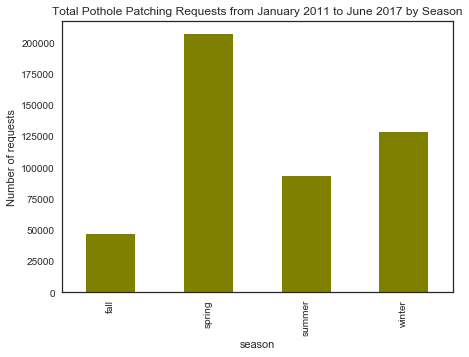

In [223]:
seasonalRequests = df.groupby('season')['clean Creation Date'].count()
fig = plt.figure(figsize=(7,5))
seasonalRequests.plot(kind='bar', color = 'olive');
plt.ylabel('Number of requests');
plt.title('Total Pothole Patching Requests from January 2011 to June 2017 by Season');

In [224]:
#Find percentage of all requests made in spring
seasonalRequests[seasonalRequests.index == 'spring'] / seasonalRequests.sum()

season
spring    0.435124
Name: clean Creation Date, dtype: float64

The number of requests in the spring is significantly higher than the other three seasons.  Since more potholes are formed in the winter, requests could be more frequent in the spring after the winter season has done its damage.  Residents may be driving more in the spring than in the winter, resulting in more complaints to the DoT.

#### Pothole reports over time

Now let's see how the frequency of pothole reporting has changed over time from 2011 to the present.

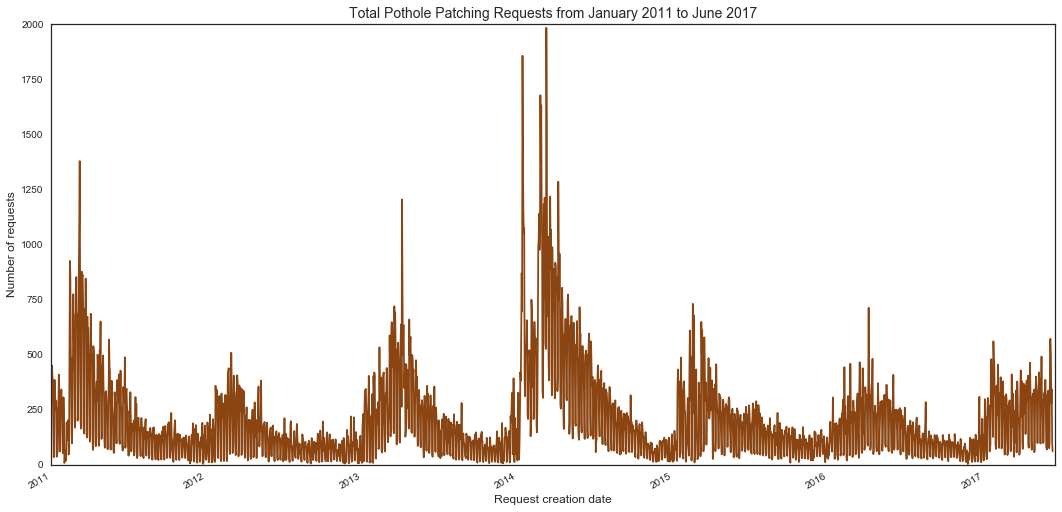

In [225]:
reportsOverTime = df.groupby('clean Creation Date')['clean Creation Date'].count()
fig = plt.figure(figsize=(18, 9))
reportsOverTime.plot(color = 'saddlebrown')
plt.xlim([datetime.datetime(2011, 1, 1, 0, 0), datetime.datetime(2017, 6, 17, 0, 0)])
plt.ylim([0,2000])
plt.ylabel('Number of requests', fontsize = 12)
plt.xlabel('Request creation date', fontsize = 12)
plt.title('Total Pothole Patching Requests from January 2011 to June 2017', fontsize = 14);

We see a dramatic spike in pothole requests in early 2014, which coincides with the infamous "polar vortex" that plunged temperatures in Chicago to record lows.  That winter also had the third-highest snowfall in Chicago history, leading to a lot of snow plowing and ultimately potholes.

### Pulling in Census Data

Unlike Chicago's wards, the community area boundaries were established in the 1920's according to neighborhood borders and haven't changed since.  A 76th community area was added to the original 75 in 1953 to include O'Hare Airport, and the final 77th area was created when Edgewater split from Uptown in 1980.  These community areas were defined to track population and economic data over time and census tracts generally lie neatly within the area boundaries to allow easy data aggregation.

CMAP (Chicago Metropolitan Agency for Planning) has compiled data by community area from the U.S. Census Bureau's 2010-14 American Community Survey, Longitudinal Employment-Household Dynamics data for 2014, and 2014/2015 data from the Illinois Department of Employment Security and the Illinois Department of Revenue.

https://datahub.cmap.illinois.gov/dataset/1d2dd970-f0a6-4736-96a1-3caeb431f5e4/resource/8c4e096e-c90c-4bef-9cf1-9028d094296e/download/ReferenceCCA20102014.csv

In [226]:
censusDF = pd.read_csv('ReferenceCCA20102014.csv')
censusDF

,GEOG,2000_POP,2010_POP,POP_CHANGE,TOT_POP,UND19,A20_34,A35_49,A50_64,A65_79,...,IND,INDperc,TRANS,TRANSperc,AG,Agperc,OPEN,OPENperc,VACANT,VACperc
0,Albany Park,57655,51542,-6113,52930,14351,14417,11908,8016,3062,...,19.929938,1.621420,414.736812,33.741335,0.000000,0.000000,25.293181,2.057752,6.672887,0.542880
1,Archer Heights,12644,13393,749,13971,4319,3277,2876,2058,1020,...,344.677590,26.848038,558.599207,43.511076,0.000000,0.000000,12.295439,0.957731,32.517216,2.532870
2,Armour Square,12032,13391,1359,13907,3037,3206,2434,2651,1639,...,18.046053,2.831079,343.648391,53.911829,0.000000,0.000000,15.019249,2.356231,14.366379,2.253809
3,Ashburn,39584,41081,1497,42809,12553,8473,8808,8724,3201,...,104.574805,3.362800,1064.249375,34.222945,0.000000,0.000000,259.867667,8.356535,83.385680,2.681424
4,Auburn Gresham,55928,48743,-7185,47611,13305,9014,8262,9515,5541,...,57.729492,2.393450,834.435659,34.595488,0.000000,0.000000,59.011603,2.446606,119.183176,4.941304
5,Austin,117527,98514,-19013,99711,30407,20747,18665,18300,9178,...,502.844219,10.992896,1464.868582,32.024128,0.000000,0.000000,199.702096,4.365774,169.487971,3.705250
6,Avalon Park,11147,10185,-962,10071,2066,2044,1669,2262,1510,...,12.597880,1.574515,316.768990,39.590583,0.000000,0.000000,28.048186,3.505533,21.171666,2.646088
7,Avondale,43083,39262,-3821,39117,9565,12319,8099,5726,2721,...,135.184040,10.650262,478.856580,37.725962,0.000000,0.000000,8.819135,0.694802,13.896510,1.094815
8,Belmont Cragin,78144,78743,599,79022,25902,18259,17142,11561,4606,...,132.786209,5.301719,775.701983,30.971242,0.000000,0.000000,64.475527,2.574297,9.427057,0.376392
9,Beverly,21992,20034,-1958,21002,5675,2967,4491,5111,2124,...,0.000000,0.000000,548.955181,26.934629,0.000000,0.000000,257.979765,12.657844,7.815703,0.383479


We need to create a key that will link the numeric community areas in the pothole data to the names included in the census datafile.

In [227]:
numbers = ['8','32','33','5','6','7','21','22','1','2','3','4','9','10','11','12','13','14','76','77','15','16','17','18','19','20','23','24','25','26','27','28','29','30','31','34','35','36','37','38','39','40','41','42','43','60','69','56','57','58','59','61','62','63','64','65','66','67','68','44','45','46','47','48','49','50','51','52','53','54','55','70','71','72','73','74','75']
names = ['Near North Side','The Loop','Near South Side','North Center','Lake View','Lincoln Park','Avondale','Logan Square','Rogers Park','West Ridge','Uptown','Lincoln Square','Edison Park','Norwood Park','Jefferson Park','Forest Glen','North Park','Albany Park','O\'Hare','Edgewater','Portage Park','Irving Park','Dunning','Montclare','Belmont Cragin','Hermosa','Humboldt Park','West Town','Austin','West Garfield Park','East Garfield Park','Near West Side','North Lawndale','South Lawndale','Lower West Side','Armour Square','Douglas','Oakland','Fuller Park','Grand Boulevard','Kenwood','Washington Park','Hyde Park','Woodlawn','South Shore','Bridgeport','Greater Grand Crossing','Garfield Ridge','Archer Heights','Brighton Park','McKinley Park','New City','West Elsdon','Gage Park','Clearing','West Lawn','Chicago Lawn','West Englewood','Englewood','Chatham','Avalon Park','South Chicago','Burnside','Calumet Heights','Roseland','Pullman','South Deering','East Side','West Pullman','Riverdale','Hegewisch','Ashburn','Auburn Gresham','Beverly','Washington Heights','Mount Greenwood','Morgan Park']
regions = ['Central','Central','Central','North Side','North Side','North Side','North Side','North Side','Far North Side','Far North Side','Far North Side','Far North Side','Far North Side','Far North Side','Far North Side','Far North Side','Far North Side','Far North Side','Far North Side','Far North Side','Northwest Side','Northwest Side','Northwest Side','Northwest Side','Northwest Side','Northwest Side','West Side','West Side','West Side','West Side','West Side','West Side','West Side','West Side','West Side','South Side','South Side','South Side','South Side','South Side','South Side','South Side','South Side','South Side','South Side','South Side','South Side','Southwest Side','Southwest Side','Southwest Side','Southwest Side','Southwest Side','Southwest Side','Southwest Side','Southwest Side','Southwest Side','Southwest Side','Southwest Side','Southwest Side','Far Southeast Side','Far Southeast Side','Far Southeast Side','Far Southeast Side','Far Southeast Side','Far Southeast Side','Far Southeast Side','Far Southeast Side','Far Southeast Side','Far Southeast Side','Far Southeast Side','Far Southeast Side','Far Southwest Side','Far Southwest Side','Far Southwest Side','Far Southwest Side','Far Southwest Side','Far Southwest Side']

In [228]:
len(numbers), len(names), len(regions)

(77, 77, 77)

In [229]:
table = [numbers, names, regions]
CA_key = pd.DataFrame(table).transpose()
CA_key.columns = ['Community Area', 'GEOG', 'CA Region']
CA_key

,Community Area,GEOG,CA Region
0,8,Near North Side,Central
1,32,The Loop,Central
2,33,Near South Side,Central
3,5,North Center,North Side
4,6,Lake View,North Side
5,7,Lincoln Park,North Side
6,21,Avondale,North Side
7,22,Logan Square,North Side
8,1,Rogers Park,Far North Side
9,2,West Ridge,Far North Side


In [230]:
censusDF_num = pd.merge(censusDF, CA_key, on='GEOG')
df = df[df['Community Area'].notnull()]
totalDF = pd.merge(df,censusDF_num, on='Community Area')
totalDF

,clean Creation Date,STATUS,clean Completion Date,SERVICE REQUEST NUMBER,TYPE OF SERVICE REQUEST,CURRENT ACTIVITY,MOST RECENT ACTION,Num_Holes_Found,X Coordinate,Y Coordinate,...,INDperc,TRANS,TRANSperc,AG,Agperc,OPEN,OPENperc,VACANT,VACperc,CA Region
0,2011-01-01,Completed - Dup,2011-01-03,11-00002110,Pot Hole in Street,None,None,NaN,1.17386e+06,1.85451e+06,...,1.894833,991.703193,43.699579,0.0,0.0,33.559291,1.478796,130.322859,5.742700,South Side
1,2011-01-01,Completed,2011-01-03,11-00002650,Pot Hole in Street,Dispatch Crew,Pothole Patched,5.0,1.18027e+06,1.85304e+06,...,1.894833,991.703193,43.699579,0.0,0.0,33.559291,1.478796,130.322859,5.742700,South Side
2,2011-01-01,Completed,2011-01-03,11-00002913,Pot Hole in Street,Dispatch Crew,Pothole Patched,10.0,1.1771e+06,1.85652e+06,...,1.894833,991.703193,43.699579,0.0,0.0,33.559291,1.478796,130.322859,5.742700,South Side
3,2011-01-01,Completed,2011-01-03,11-00002927,Pot Hole in Street,Dispatch Crew,Pothole Patched,12.0,1.17759e+06,1.85463e+06,...,1.894833,991.703193,43.699579,0.0,0.0,33.559291,1.478796,130.322859,5.742700,South Side
4,2011-01-01,Completed,2011-01-03,11-00003428,Pot Hole in Street,Dispatch Crew,Pothole Patched,2.0,1.17708e+06,1.85726e+06,...,1.894833,991.703193,43.699579,0.0,0.0,33.559291,1.478796,130.322859,5.742700,South Side
5,2012-01-01,Completed,2012-01-05,12-00001061,Pot Hole in Street,Dispatch Crew,Pothole Patched,47.0,1.1829e+06,1.85413e+06,...,1.894833,991.703193,43.699579,0.0,0.0,33.559291,1.478796,130.322859,5.742700,South Side
6,2011-01-02,Completed - Dup,2011-01-03,11-00003855,Pot Hole in Street,None,None,NaN,1.1771e+06,1.85653e+06,...,1.894833,991.703193,43.699579,0.0,0.0,33.559291,1.478796,130.322859,5.742700,South Side
7,2011-01-02,Completed,2011-01-03,11-00004006,Pot Hole in Street,Dispatch Crew,Pothole Patched,8.0,1.17428e+06,1.85453e+06,...,1.894833,991.703193,43.699579,0.0,0.0,33.559291,1.478796,130.322859,5.742700,South Side
8,2013-01-02,Completed,2013-01-02,13-00005494,Pot Hole in Street,Final Outcome,Pothole Patched,6.0,1.18518e+06,1.85751e+06,...,1.894833,991.703193,43.699579,0.0,0.0,33.559291,1.478796,130.322859,5.742700,South Side
9,2013-01-02,Completed,2013-01-02,13-00005509,Pot Hole in Street,Final Outcome,Pothole Patched,27.0,1.18548e+06,1.85685e+06,...,1.894833,991.703193,43.699579,0.0,0.0,33.559291,1.478796,130.322859,5.742700,South Side


In [231]:
list(totalDF.columns)

['clean Creation Date',
 'STATUS',
 'clean Completion Date',
 'SERVICE REQUEST NUMBER',
 'TYPE OF SERVICE REQUEST',
 'CURRENT ACTIVITY',
 'MOST RECENT ACTION',
 'Num_Holes_Found',
 'X Coordinate',
 'Y Coordinate',
 'Latitude',
 'Longitude',
 'STREET ADDRESS',
 'ZIP',
 'Ward',
 'Police District',
 'Community Area',
 'SSA',
 'timePassed',
 'season',
 'GEOG',
 '2000_POP',
 '2010_POP',
 'POP_CHANGE',
 'TOT_POP',
 'UND19',
 'A20_34',
 'A35_49',
 'A50_64',
 'A65_79',
 'OV80',
 'MED_AGE',
 'WHITE',
 'HISP',
 'BLACK',
 'ASIAN',
 'OTHER',
 'POP_HH',
 'POP_16OV',
 'IN_LBFRC',
 'EMP',
 'UNEMP',
 'NOT_IN_LBFRC',
 'WORK_AT_HOME',
 'TOT_COMM',
 'DROVE_AL',
 'CARPOOL',
 'TRANSIT',
 'WALK_BIKE',
 'COMM_OTHER',
 'POP_25OV',
 'HS',
 'BACH',
 'INC_LT_25K',
 'INC_25_50K',
 'INC_50_75K',
 'INC_75_100K',
 'INC_100_150K',
 'INC_GT_150',
 'MEDINC',
 'TOT_HH',
 'OWN_OCC_HU',
 'RENT_OCC_HU',
 'VAC_HU',
 'HU_TOT',
 'HU_SNG_DET',
 'HU_SNG_ATT',
 'HU_2UN',
 'HU_3_4UN',
 'HU_GT_5UN',
 'MED_ROOMS',
 'HA_AFT2000',
 '

In [232]:
#Check to see that all community areas are linked up between the census dataset and the pothole dataset
areas_in_df = totalDF.groupby(['Community Area'])['Community Area'].count()
check_num = areas_in_df.index
CA_key.insert(1, 'CA Numbers in DF', CA_key['Community Area'].isin(check_num))
CA_key[CA_key['CA Numbers in DF'] == False]

,Community Area,CA Numbers in DF,GEOG,CA Region


#### Pothole requests by community area

Let's first look at how pothole requests compare when we look at community areas (CA's).

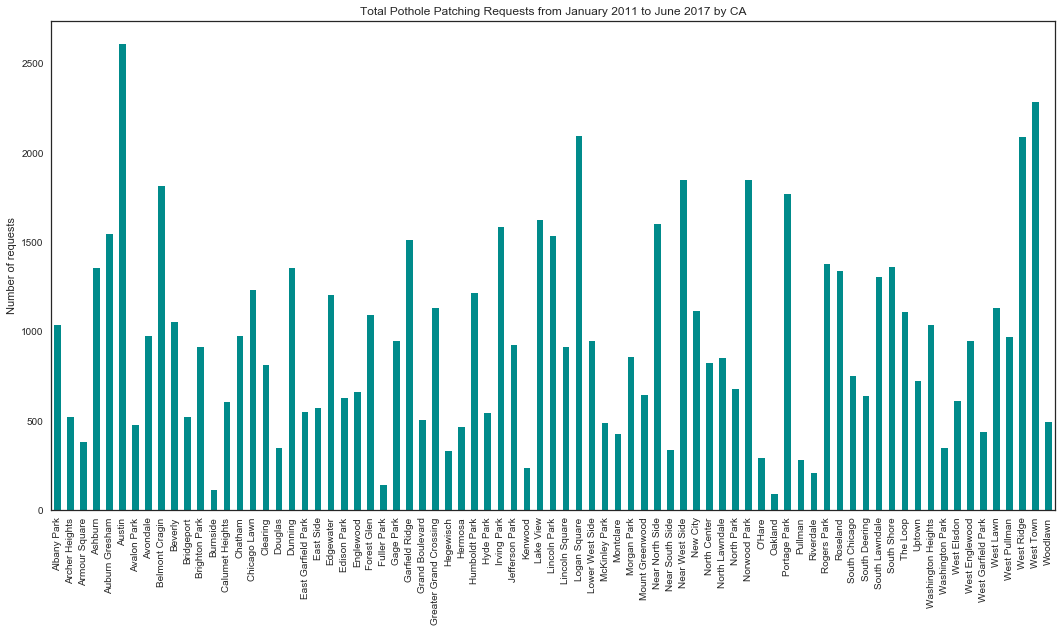

In [233]:
#Divide CA_requests by 6.5 to find annual requests
CA_requests = totalDF.groupby('GEOG')['clean Creation Date'].count() / 6.5
fig = plt.figure(figsize=(18, 9))
CA_requests.plot(kind='bar', color = 'darkcyan');
plt.ylabel('Number of requests');
plt.xlabel('');
plt.title('Total Pothole Patching Requests from January 2011 to June 2017 by CA');

Interestingly, we see that O'Hare actually has one of the smallest number of total requests when we look at community areas.  Possibly the number of requests is tied to the number of residents, and O'Hare is sparsely populated around the airport.

Next, we'll look at how requests vary by region.

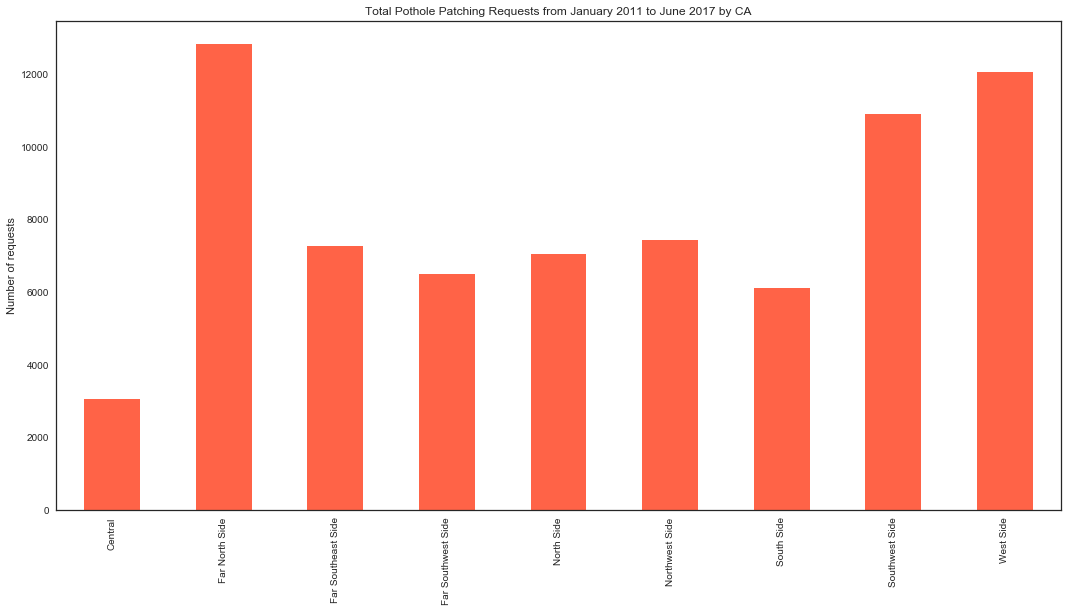

In [234]:
CA_requests_region = totalDF.groupby('CA Region')['clean Creation Date'].count() / 6.5
fig = plt.figure(figsize=(18, 9))
CA_requests_region.plot(kind='bar', color = 'tomato');
plt.ylabel('Number of requests');
plt.xlabel('');
plt.title('Total Pothole Patching Requests from January 2011 to June 2017 by CA');

We see that the Central region has the lowest number of annual requests.

#### Population by CA

Now let's look at population in each community area.

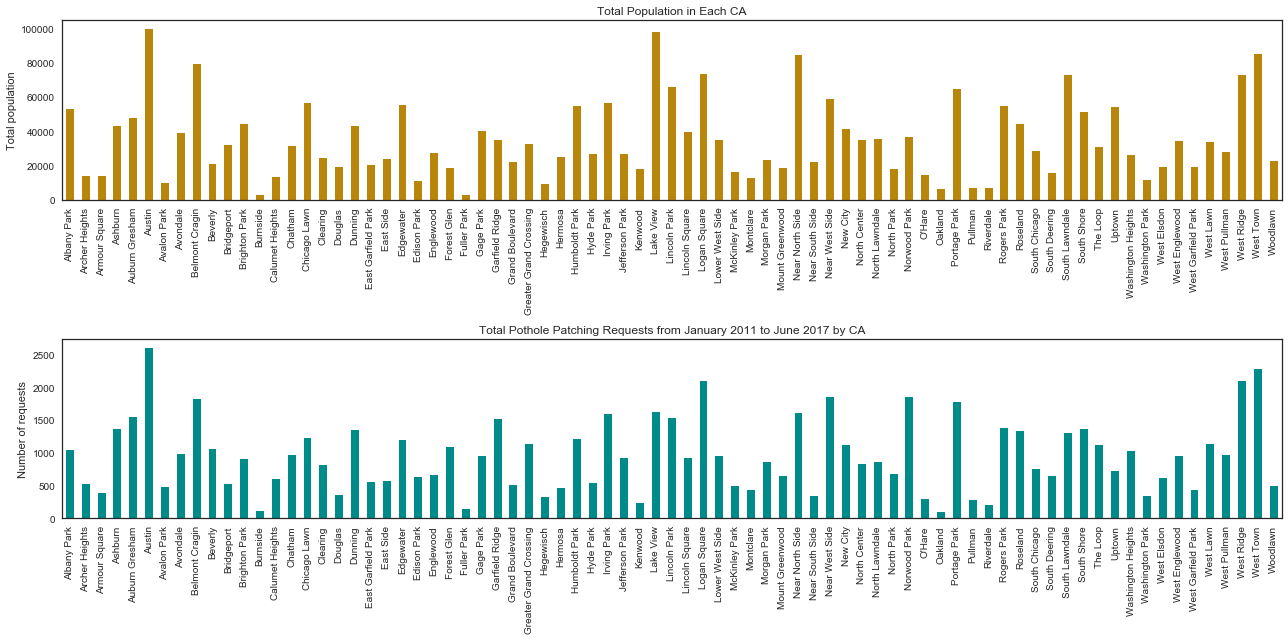

In [235]:
population = censusDF.TOT_POP.copy() 
population.index = list(censusDF.GEOG)

fig = plt.figure(figsize=(18, 9));
plt.subplot(2,1,1)
population.plot.bar(color = 'darkgoldenrod');
plt.ylabel('Total population');
plt.title('Total Population in Each CA');

plt.subplot(2,1,2)
CA_requests.plot(kind='bar', color = 'darkcyan');
plt.ylabel('Number of requests');
plt.xlabel('');
plt.title('Total Pothole Patching Requests from January 2011 to June 2017 by CA');
fig.tight_layout()

The pothole request plot and the population plot by CA are strikingly similar (as we can see from the overlay above).  Let's take a more direct look at how population correlates with the number of requests.

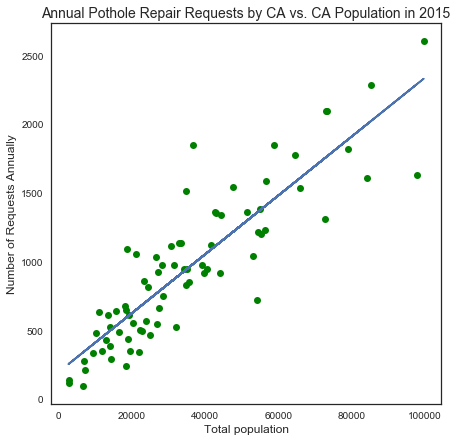

In [236]:
fig = plt.figure(figsize=(7,7));
plt.plot(population, CA_requests, 'go');
plt.ylabel('Number of Requests Annually', fontsize = 12)
plt.xlabel('Total population', fontsize = 12);
plt.title('Annual Pothole Repair Requests by CA vs. CA Population in 2015', fontsize = 14);

from scipy.stats import linregress
slope, intercept, r, p, stderr = linregress(population, CA_requests)
line_values = [slope * i + intercept for i in list(population)]
plt.plot(list(population), line_values);

We see a very clear linear relationship here. A linear regression line was added with output displayed below.  The fit is decent with an r-value of 0.88.  We also have a very small p-value of 4.69e-26 so we can reject the null hypothesis that the slope is zero.  The slope given by the regression line is approximately 0.021 requests per person per year, irrespective of which community area they reside in.

In [237]:
linregress(population, CA_requests)

LinregressResult(slope=0.021371509115948567, intercept=197.86797466517271, rvalue=0.88074941969991594, pvalue=4.689993424564648e-26, stderr=0.0013269296904389676)

#### Number of requests by CA

Let's compare how often requests are filed with the Department of Transportation with how many potholes are found on each block when the DoT arrives by community area.  We can hypothesize that when fewer requests are filed, the crew finds more potholes to fill since they tend to that community area less frequently than others where more requests are filed.  We'll also compare these variables again response time to understand the correlation.

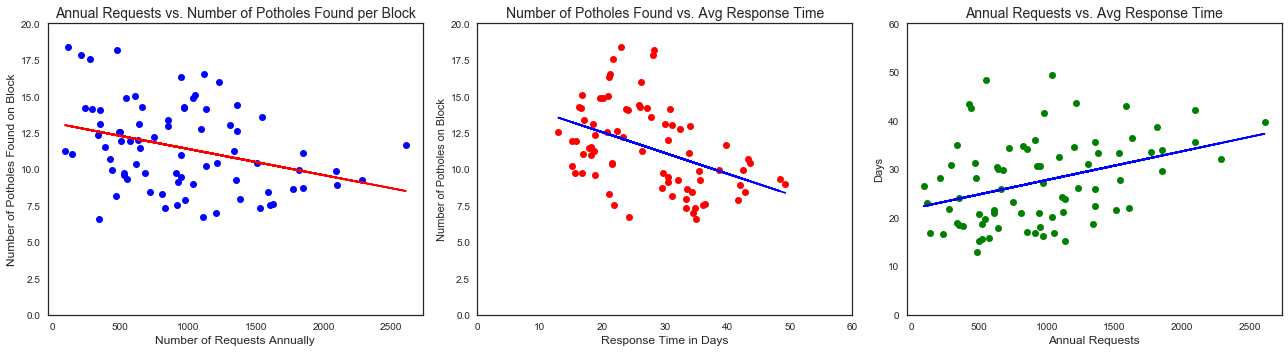

In [238]:
#Combine average number of potholes per block and number of annual requests by community area
avgPotholeNumByCA = totalDF.groupby('GEOG')['Num_Holes_Found'].mean()
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.plot(CA_requests, avgPotholeNumByCA, 'bo');
plt.ylabel('Number of Potholes Found on Block', fontsize = 12);
plt.xlabel('Number of Requests Annually', fontsize = 12);
plt.ylim([0,20]);
plt.title('Annual Requests vs. Number of Potholes Found per Block', fontsize = 14);

#Add regression line
slope, intercept, r, p, stderr = linregress(CA_requests, avgPotholeNumByCA)
line_values = [slope * i + intercept for i in list(CA_requests)]
plt.plot(list(CA_requests), line_values, '-r');

avgDaysCA = totalDF.groupby('GEOG')['timePassed'].mean()

plt.subplot(1,3,2)
plt.plot(avgDaysCA, avgPotholeNumByCA, 'ro');
plt.ylabel('Number of Potholes on Block');
plt.xlabel('Response Time in Days', fontsize = 12);
plt.ylim([0,20]);
plt.xlim([0,60]);
plt.title('Number of Potholes Found vs. Avg Response Time', fontsize = 14);

#Add regression line
slope, intercept, r, p, stderr = linregress(avgDaysCA, avgPotholeNumByCA)
line_values = [slope * i + intercept for i in list(avgDaysCA)]
plt.plot(list(avgDaysCA), line_values, '-b');
fig.tight_layout()

plt.subplot(1,3,3)
plt.plot(CA_requests, avgDaysCA, 'go');
plt.ylabel('Days');
plt.xlabel('Annual Requests', fontsize = 12);
plt.ylim([0,60]);
plt.title('Annual Requests vs. Avg Response Time', fontsize = 14);

#Add regression line
slope, intercept, r, p, stderr = linregress(CA_requests, avgDaysCA,)
line_values = [slope * i + intercept for i in list(CA_requests)]
plt.plot(list(CA_requests), line_values, '-b');
fig.tight_layout()

We can see trends in the annual request data against all three variables above.

In [239]:
print(np.corrcoef([avgDaysCA, CA_requests, avgPotholeNumByCA]))

[[ 1.          0.36573939 -0.42820668]
 [ 0.36573939  1.         -0.33370238]
 [-0.42820668 -0.33370238  1.        ]]


The correlation matrix shows that a linear regression is a good fit for the data.

#### Median income

CMAP provides information on median income by community area.  Let's see how that affects the number of pothole repair requests.

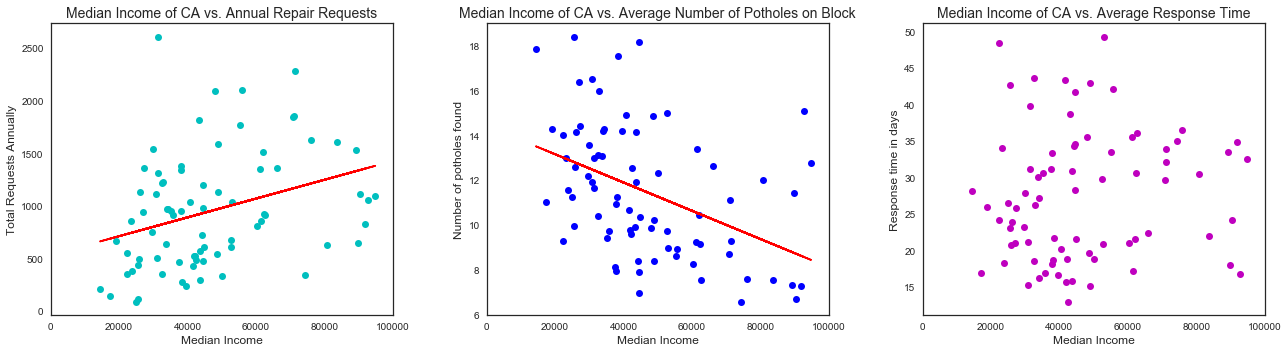

In [240]:
medIncome = censusDF.MEDINC.copy() 
medIncome.index = list(censusDF.GEOG)

fig = plt.figure(figsize=(18,5));
plt.subplot(1,3,1)
plt.plot(medIncome, CA_requests, 'co');
plt.xlim([0,100000])
plt.xlabel('Median Income', fontsize = 12);
plt.ylabel('Total Requests Annually', fontsize = 12);
plt.title('Median Income of CA vs. Annual Repair Requests', fontsize = 14);

#Add regression line
slope, intercept, r, p, stderr = linregress(medIncome, CA_requests)
line_values = [slope * i + intercept for i in list(medIncome)]
plt.plot(list(medIncome), line_values, '-r');

plt.subplot(1,3,2)
plt.plot(medIncome, avgPotholeNumByCA, 'bo');
plt.xlim([0,100000])
plt.xlabel('Median Income', fontsize = 12);
plt.ylabel('Number of potholes found', fontsize = 12);
plt.title('Median Income of CA vs. Average Number of Potholes on Block', fontsize = 14);

#Add regression line
slope, intercept, r, p, stderr = linregress(medIncome, avgPotholeNumByCA)
line_values = [slope * i + intercept for i in list(medIncome)]
plt.plot(list(medIncome), line_values, '-r');

CA_response = totalDF.groupby(['GEOG'])['timePassed'].mean()

plt.subplot(1,3,3)
plt.plot(medIncome, avgDaysCA, 'mo');
plt.xlim([0,100000])
plt.xlabel('Median Income', fontsize = 12);
plt.ylabel('Response time in days', fontsize = 12);
plt.title('Median Income of CA vs. Average Response Time', fontsize = 14);
fig.tight_layout()

In [241]:
pd.DataFrame(np.corrcoef([medIncome, avgDaysCA, CA_requests, avgPotholeNumByCA]))

,0,1,2,3
0,1.000000,0.088111,0.330599,-0.433146
1,0.088111,1.000000,0.365739,-0.428207
2,0.330599,0.365739,1.000000,-0.333702
3,-0.433146,-0.428207,-0.333702,1.000000


#### Mode of transport

CMAP provides data on the method of transportation residents use to get to work.  We'll combine the categories for driving alone and carpooling to understand what percentage of the CA's residents are adding vehicular traffic to their roads.

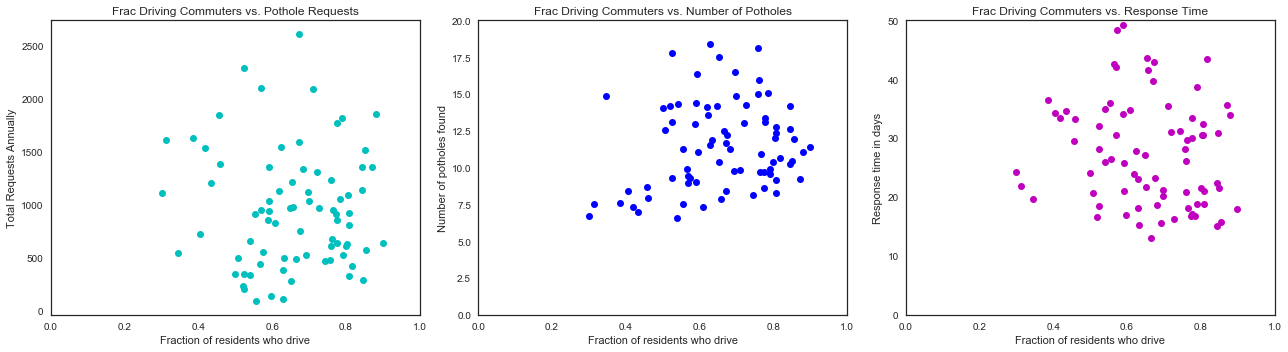

In [242]:
drivers = censusDF.DROVE_AL + censusDF.CARPOOL
driverPct = drivers / censusDF.TOT_COMM
driverPct.index = list(censusDF.GEOG)

fig = plt.figure(figsize=(18,5));
plt.subplot(1,3,1)
plt.plot(driverPct, CA_requests, 'co');
plt.xlim([0,1])
plt.xlabel('Fraction of residents who drive');
plt.ylabel('Total Requests Annually');
plt.title('Frac Driving Commuters vs. Pothole Requests');

plt.subplot(1,3,2)
plt.plot(driverPct, avgPotholeNumByCA, 'bo');
plt.xlim([0,1])
plt.xlabel('Fraction of residents who drive');
plt.ylabel('Number of potholes found');
plt.ylim([0,20]);
plt.title('Frac Driving Commuters vs. Number of Potholes');

plt.subplot(1,3,3)
plt.plot(driverPct, CA_response, 'mo');
plt.xlim([0,1])
plt.ylim([0,50])
plt.xlabel('Fraction of residents who drive');
plt.ylabel('Response time in days');
plt.title('Frac Driving Commuters vs. Response Time');

plt.tight_layout()

No correlation appears in the scatterplots.

In [243]:
np.corrcoef([driverPct, avgDaysCA, CA_requests, avgPotholeNumByCA])

array([[ 1.        , -0.15527665, -0.031391  ,  0.20108439],
       [-0.15527665,  1.        ,  0.36573939, -0.42820668],
       [-0.031391  ,  0.36573939,  1.        , -0.33370238],
       [ 0.20108439, -0.42820668, -0.33370238,  1.        ]])

#### Percentage of roads

Next, we'll see how the percentage of land classified as "transportation" compares to number of requests, potholes per block, and response time.  CMAP conducts a land-use survey and includes a "transportation" category that can include roads, railways, and airfields.  With the exception of O'Hare, Clearing and Garfield Ridge (these last two each contain a half of Midway Airport), we will assume that the majority of this classification in the community areas is for roadways.

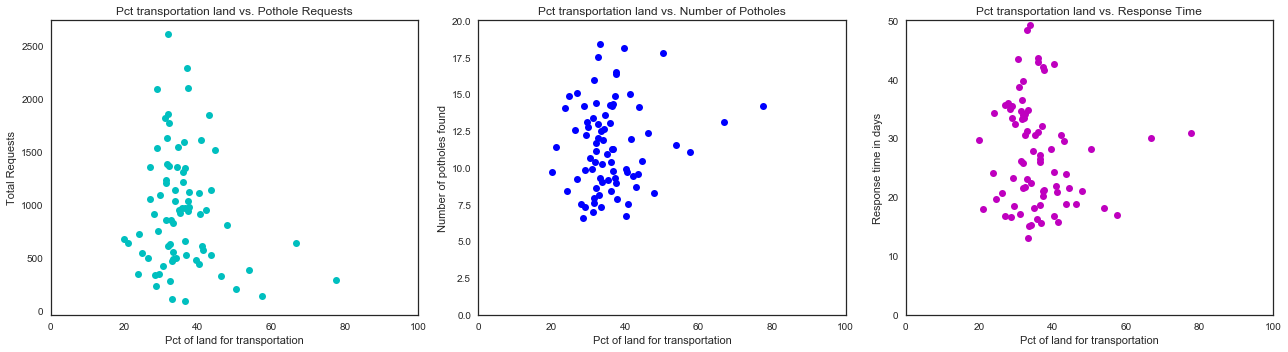

In [244]:
trans = censusDF.TRANSperc.copy()
trans.index = list(censusDF.GEOG)

fig = plt.figure(figsize=(18,5));
plt.subplot(1,3,1)
plt.plot(trans, CA_requests, 'co');
plt.xlim([0,100])
plt.xlabel('Pct of land for transportation');
plt.ylabel('Total Requests');
plt.title('Pct transportation land vs. Pothole Requests');

plt.subplot(1,3,2)
plt.plot(trans, avgPotholeNumByCA, 'bo');
plt.xlim([0,100])
plt.xlabel('Pct of land for transportation');
plt.ylabel('Number of potholes found');
plt.ylim([0,20]);
plt.title('Pct transportation land vs. Number of Potholes');

plt.subplot(1,3,3)
plt.plot(trans, CA_response, 'mo');
plt.xlim([0,100])
plt.ylim([0,50])
plt.xlabel('Pct of land for transportation');
plt.ylabel('Response time in days');
plt.title('Pct transportation land vs. Response Time');

plt.tight_layout()

In [245]:
trans[trans > 50]

Armour Square    53.911829
Fuller Park      57.598451
O'Hare           77.552566
Riverdale        50.417839
South Deering    66.775113
Name: TRANSperc, dtype: float64

With a few outliers (seen above), most community areas are consistently within the 20-50% range for percent of land used for transportation.  Without much variability, we don't expect to find a correlation with this variable.

#### Residential vs. Commercial Use

Do residential areas prioritize pothole reporting over commerical ones?

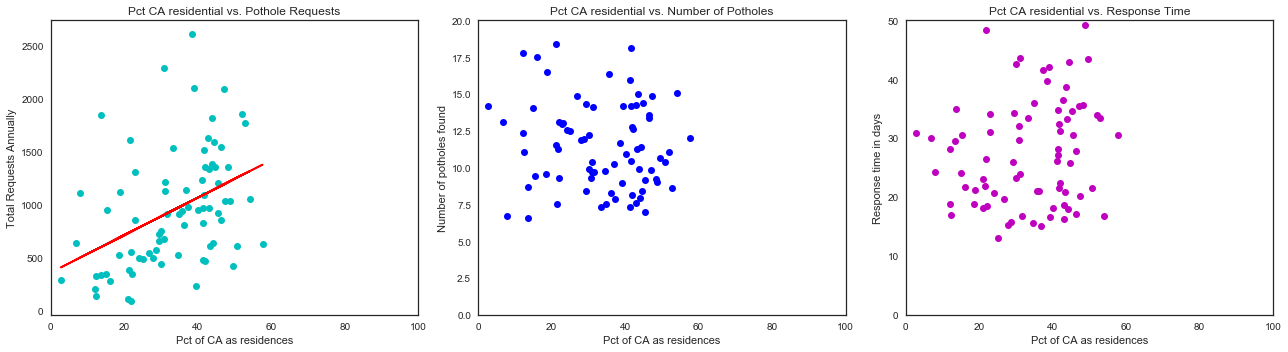

In [246]:
resid = censusDF.Sfperc + censusDF.Mfperc

fig = plt.figure(figsize=(18,5));
plt.subplot(1,3,1)
plt.plot(resid, CA_requests, 'co');
plt.xlim([0,100])
plt.xlabel('Pct of CA as residences');
plt.ylabel('Total Requests Annually');
plt.title('Pct CA residential vs. Pothole Requests');

#Add regression line
slope, intercept, r, p, stderr = linregress(resid, CA_requests)
line_values = [slope * i + intercept for i in list(resid)]
plt.plot(list(resid), line_values, '-r');

plt.subplot(1,3,2)
plt.plot(resid, avgPotholeNumByCA, 'bo');
plt.xlim([0,100])
plt.xlabel('Pct of CA as residences');
plt.ylabel('Number of potholes found');
plt.ylim([0,20]);
plt.title('Pct CA residential vs. Number of Potholes');

plt.subplot(1,3,3)
plt.plot(resid, CA_response, 'mo');
plt.xlim([0,100])
plt.ylim([0,50])
plt.xlabel('Pct of CA as residences');
plt.ylabel('Response time in days');
plt.title('Pct CA residential vs. Response Time');

plt.tight_layout()

In [247]:
pd.DataFrame(np.corrcoef([resid,  avgDaysCA, CA_requests, avgPotholeNumByCA]))

,0,1,2,3
0,1.000000,0.169667,0.414048,-0.112761
1,0.169667,1.000000,0.365739,-0.428207
2,0.414048,0.365739,1.000000,-0.333702
3,-0.112761,-0.428207,-0.333702,1.000000


While no correlations appear for the number of potholes found per block or for response time, there may be a positive correlation between the percentage of residential area and the number of repair requests submitted.  Linregress proves that this is the case.

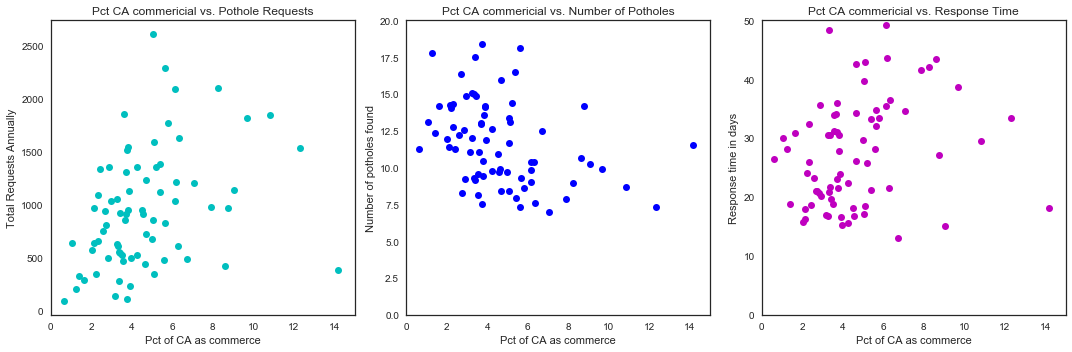

In [248]:
comm = censusDF.COMMperc.copy()
comm.index = list(censusDF.GEOG)

fig = plt.figure(figsize=(15,5));
plt.subplot(1,3,1)
plt.plot(comm, CA_requests, 'co');
plt.xlim([0,15])
plt.xlabel('Pct of CA as commerce');
plt.ylabel('Total Requests Annually');
plt.title('Pct CA commericial vs. Pothole Requests');

plt.subplot(1,3,2)
plt.plot(comm, avgPotholeNumByCA, 'bo');
plt.xlim([0,15])
plt.xlabel('Pct of CA as commerce');
plt.ylabel('Number of potholes found');
plt.ylim([0,20]);
plt.title('Pct CA commericial vs. Number of Potholes');

plt.subplot(1,3,3)
plt.plot(comm, CA_response, 'mo');
plt.xlim([0,15])
plt.ylim([0,50])
plt.xlabel('Pct of CA as commerce');
plt.ylabel('Response time in days');
plt.title('Pct CA commericial vs. Response Time');

plt.tight_layout()

In [249]:
pd.DataFrame(np.corrcoef([comm[comm < 15], CA_requests.drop(['The Loop', 'Near North Side', 'Near South Side']), CA_response.drop(['The Loop', 'Near North Side', 'Near South Side']),avgPotholeNumByCA.drop(['The Loop', 'Near North Side', 'Near South Side'])])) 

,0,1,2,3
0,1.000000,0.355255,0.247534,-0.355052
1,0.355255,1.000000,0.399907,-0.354198
2,0.247534,0.399907,1.000000,-0.454726
3,-0.355052,-0.354198,-0.454726,1.000000


As with the transportation land usage data, we don't have much variability with commericial usage.  Almost all CA's have less than 10% commercial space.  Outliers (all in the central region) are shown below.

In [250]:
comm[comm > 15]

Near North Side    16.710698
Near South Side    28.689738
The Loop           20.634199
Name: COMMperc, dtype: float64

For good measure, we'll also analyze industrial usage.

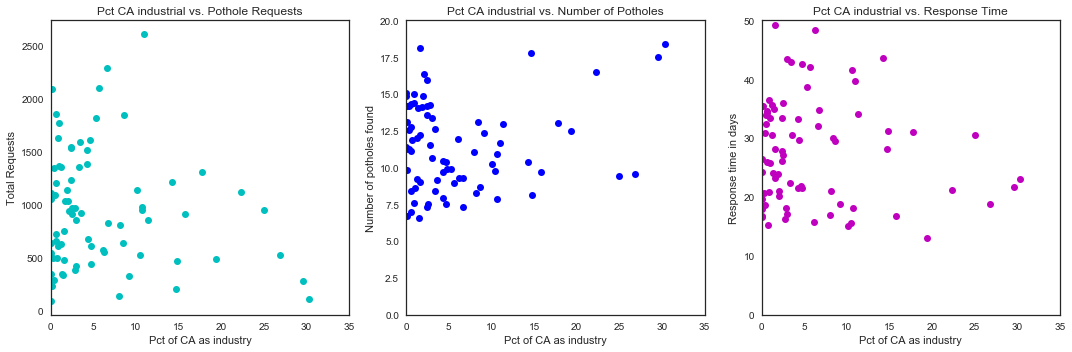

In [251]:
ind = censusDF.INDperc.copy()
ind.index = list(censusDF.GEOG)

fig = plt.figure(figsize=(15,5));
plt.subplot(1,3,1)
plt.plot(ind, CA_requests, 'co');
plt.xlim([0,35])
plt.xlabel('Pct of CA as industry');
plt.ylabel('Total Requests');
plt.title('Pct CA industrial vs. Pothole Requests');

plt.subplot(1,3,2)
plt.plot(ind, avgPotholeNumByCA, 'bo');
plt.xlim([0,35])
plt.xlabel('Pct of CA as industry');
plt.ylabel('Number of potholes found');
plt.ylim([0,20]);
plt.title('Pct CA industrial vs. Number of Potholes');

plt.subplot(1,3,3)
plt.plot(ind, CA_response, 'mo');
plt.xlim([0,35])
plt.ylim([0,50])
plt.xlabel('Pct of CA as industry');
plt.ylabel('Response time in days');
plt.title('Pct CA industrial vs. Response Time');

plt.tight_layout()

Again, we see no correlation.

#### Average wait time by CA

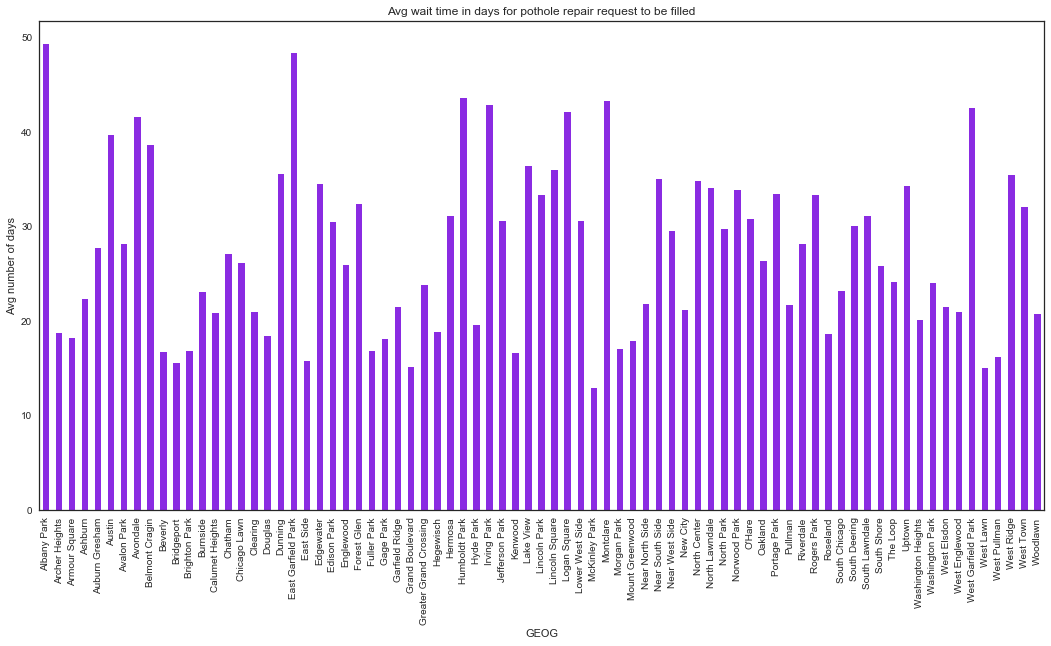

In [252]:
avgDaysCA = totalDF.groupby(['GEOG'])['timePassed'].mean()
fig = plt.figure(figsize=(18,9));
avgDaysCA.plot(kind = 'bar', color = 'blueviolet');
plt.ylabel('Avg number of days');
plt.title('Avg wait time in days for pothole repair request to be filled');

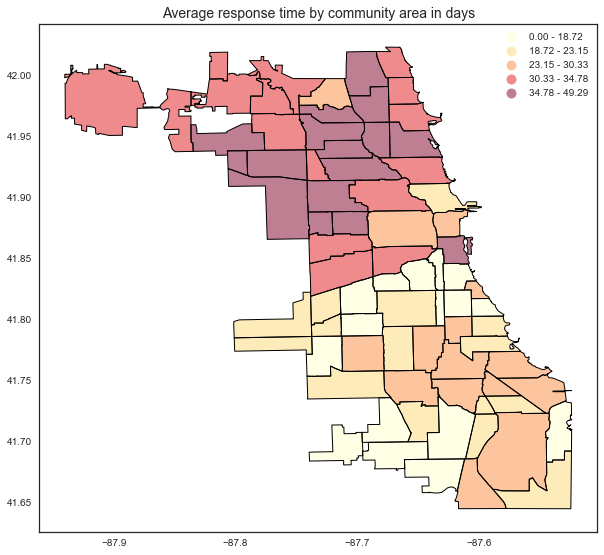

In [253]:
#Make a chloropleth
import geopandas as gpd
# read the shapefile as a GeoDataFrame
sf = gpd.GeoDataFrame.from_file("Shapefile/Chi_CC.shp")

#Some tweaking of avgDaysCA series before merging
avgDaysCA_geo = avgDaysCA.copy()
avgDaysCA_geo.index = avgDaysCA_geo.index.str.upper()
avgDaysCA_geo.index.name = 'community'
days_geo = avgDaysCA_geo.to_frame().reset_index().set_value(54, 'community', 'OHARE')
days_geo = days_geo.set_value(65, 'community', 'LOOP')

response_map = pd.merge(sf,days_geo,on='community')
ax = response_map.plot(column='timePassed', scheme='quantiles', k=5, cmap='YlOrRd', legend=True, figsize=(10,20));
ax.set_title('Average response time by community area in days', fontsize = 14);

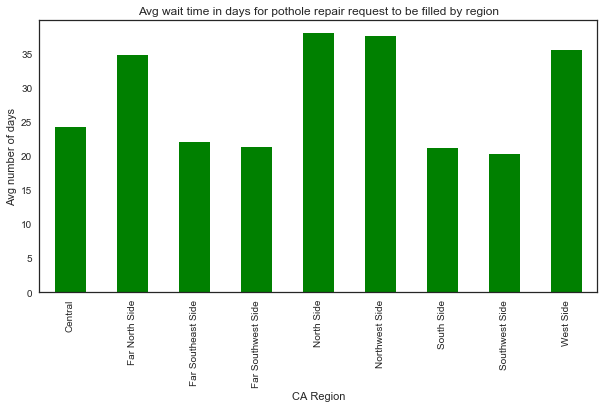

In [254]:
#Let's look at average wait time by region
avgDaysRegion = totalDF.groupby(['CA Region'])['timePassed'].mean()
fig = plt.figure(figsize=(10,5));
avgDaysRegion.plot(kind = 'bar', color = 'g');
plt.ylabel('Avg number of days');
plt.title('Avg wait time in days for pothole repair request to be filled by region');

In [255]:
avgDaysCA[avgDaysCA < 20]

GEOG
Archer Heights     18.781575
Armour Square      18.220753
Beverly            16.741133
Bridgeport         15.601001
Brighton Park      16.837127
Douglas            18.499780
East Side          15.811733
Fuller Park        16.876503
Gage Park          18.131468
Grand Boulevard    15.203613
Hegewisch          18.847125
Hyde Park          19.664192
Kenwood            16.653048
McKinley Park      12.970653
Morgan Park        17.118704
Mount Greenwood    17.936923
Roseland           18.698802
West Lawn          15.102473
West Pullman       16.256124
Name: timePassed, dtype: float64

In [256]:
avgDaysCA[avgDaysCA > 40]

GEOG
Albany Park           49.294273
Avondale              41.650876
East Garfield Park    48.367209
Humboldt Park         43.623784
Irving Park           42.893550
Logan Square          42.113989
Montclare             43.367752
West Garfield Park    42.603040
Name: timePassed, dtype: float64

#### Seasonal wait time

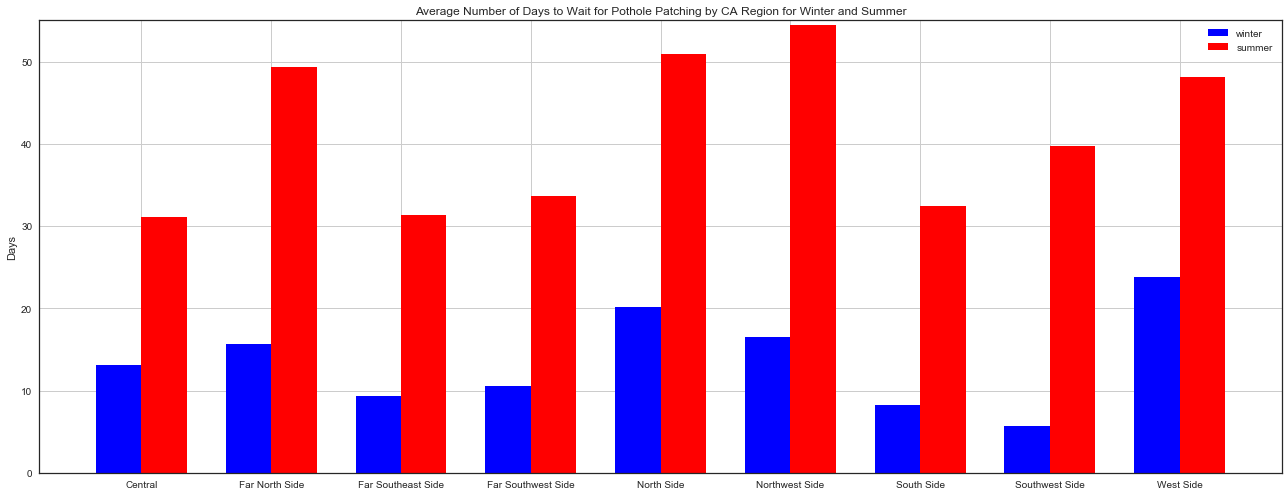

In [257]:
avgDaysSeasonCA = totalDF.groupby(['season','CA Region'])['timePassed'].mean()

#We'll only look at winter and summer as the two extreme seasons
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(111)
ind = np.arange(9)
win_plot = plt.bar(ind, avgDaysSeasonCA['winter'], width = 0.35, color = 'b')
sum_plot = plt.bar(ind + 0.35, avgDaysSeasonCA['summer'], width = 0.35, color = 'r')
plt.ylabel('Days');
plt.ylim([0,55])
plt.title('Average Number of Days to Wait for Pothole Patching by CA Region for Winter and Summer');

ax.set_xticks(ind + 0.35/2)
ax.set_xticklabels(avgDaysSeasonCA['winter'].index);
ax.legend([win_plot, sum_plot], ['winter','summer'], loc='best')
ax.grid(True)
fig.tight_layout()

Wait times by region relative to each other seem to remain stable between seasons.  Is there a greater increase in wait time in the summer on the south side vs. the north?

In [258]:
#Filter master dataframe into regions showing only north or south
north = totalDF[totalDF['CA Region'].str.contains('North')]
north.groupby('CA Region')['CA Region'].count()

CA Region
Far North Side    83329
North Side        45892
Northwest Side    48254
Name: CA Region, dtype: int64

In [259]:
south = totalDF[totalDF['CA Region'].str.contains('South')]
south.groupby('CA Region')['CA Region'].count()

CA Region
Far Southeast Side    47286
Far Southwest Side    42196
South Side            39764
Southwest Side        70844
Name: CA Region, dtype: int64

In [260]:
#Check for equal variance between two samples
print('Southern region std on wait time: {:.2f} \nNorthern region std on wait time: {:.2f}'.format(south['timePassed'].std(), north['timePassed'].std()))

Southern region std on wait time: 48.08 
Northern region std on wait time: 66.07


In [261]:
#Let's see what the difference in means is between south and north wait times
print('Southern region avg wait time in days: {:.2f} \nNorthern region avg wait time in days: {:.2f}'.format(south['timePassed'].mean(), north['timePassed'].mean()))

Southern region avg wait time in days: 21.09 
Northern region avg wait time in days: 36.40


In [262]:
#Set equal variance to false to perform Welch's t-test as we do not have equal variances between the samples
stats.ttest_ind(north['timePassed'].dropna(), south['timePassed'].dropna(), equal_var=False)

Ttest_indResult(statistic=79.243869264081525, pvalue=0.0)

A two sample t-test performed on southern and northern regions shows that we can reject the null hypothesis that the difference in average wait time for each region is zero.  We have a very small p-value for this two-tailed test.  To convert to a one-tailed test, we see that our t-statistic is positive, indicating that a one-tailed null hypothesis of northern regions waiting less time than southern regions can be rejected.  Therefore, we can conclude that northern community areas wait longer than southern areas on average for pothole repairs.

In [263]:
#Create series by finding mean wait time by community area in both winter and summer and subtracting for both regions
southWaitInc = south[south['season'] == 'summer'].groupby('GEOG')['timePassed'].mean().subtract(south[south['season'] == 'winter'].groupby('GEOG')['timePassed'].mean())
northWaitInc = north[north['season'] == 'summer'].groupby('GEOG')['timePassed'].mean().subtract(north[north['season'] == 'winter'].groupby('GEOG')['timePassed'].mean())
avgWaitInc = totalDF[totalDF['season'] == 'summer'].groupby('GEOG')['timePassed'].mean().subtract(totalDF[totalDF['season'] == 'winter'].groupby('GEOG')['timePassed'].mean())
print('Average wait time increase (days): {:.2f} \nSouthern average wait time increase (days): {:.2f} \nNorthern average wait time increase (days): {:.2f}'.format(avgWaitInc.mean(), southWaitInc.mean(), northWaitInc.mean()))

Average wait time increase (days): 28.26 
Southern average wait time increase (days): 27.01 
Northern average wait time increase (days): 33.55


In [264]:
print('Southern std wait time increase: {:.2f} \nNorthern std wait time increase: {:.2f}'.format(southWaitInc.std(), northWaitInc.std()))

Southern std wait time increase: 8.91 
Northern std wait time increase: 7.37


In [265]:
stats.ttest_ind(northWaitInc, southWaitInc, equal_var = False)

Ttest_indResult(statistic=3.1718195898170509, pvalue=0.0025174028101638594)

As we are performing a one-tailed t-test with a null hypothesis that winter wait times in southern regions are the same or less than the average wait time increase from summer to winter for northern community areas.  The results above are for a two-tailed test, and when we divide by two to account for a one-tailed test, our p-value is below 0.05.  We can reject the null hypothesis and conclude that the wait time increase from winter to summer is greater for northern community areas compared to those in the south. 

#### Reports over time by region

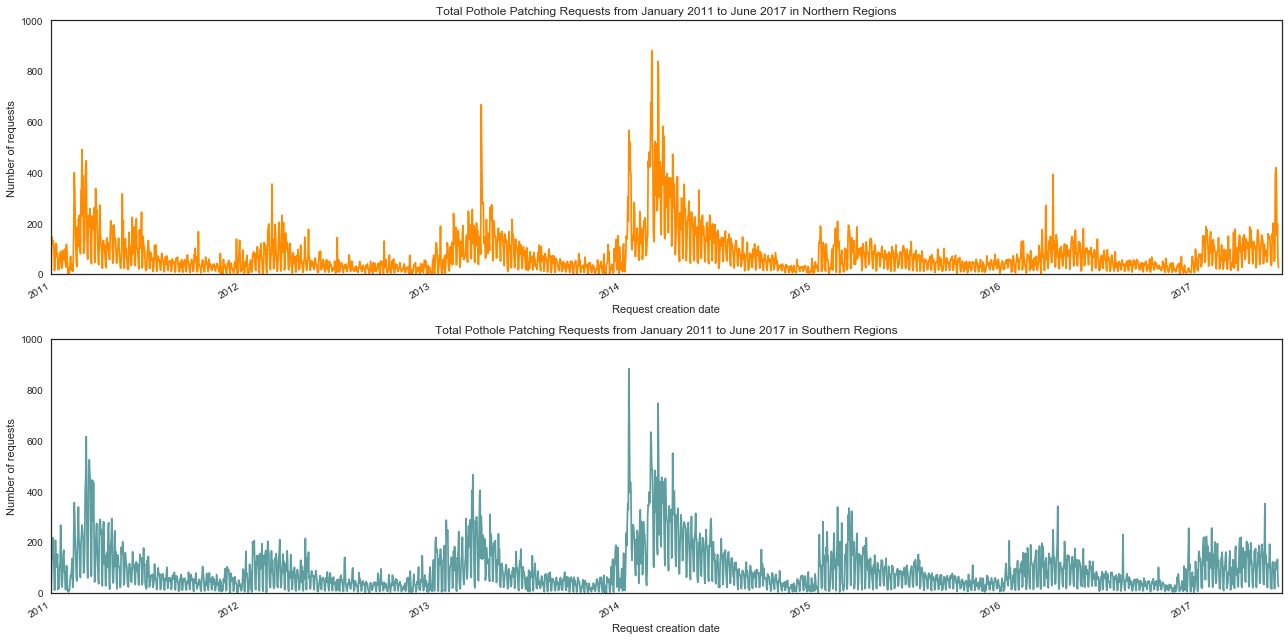

In [266]:
northReports = north.groupby('clean Creation Date')['clean Creation Date'].count()
southReports = south.groupby('clean Creation Date')['clean Creation Date'].count()

fig = plt.figure(figsize=(18, 9))
plt.subplot(2, 1, 1)
northReports.plot(color = 'darkorange')
plt.xlim([datetime.datetime(2011, 1, 1, 0, 0), datetime.datetime(2017, 6, 17, 0, 0)])
plt.ylim([0,1000])
plt.ylabel('Number of requests')
plt.xlabel('Request creation date')
plt.title('Total Pothole Patching Requests from January 2011 to June 2017 in Northern Regions');

plt.subplot(2, 1, 2)
southReports.plot(color = 'cadetblue')
plt.xlim([datetime.datetime(2011, 1, 1, 0, 0), datetime.datetime(2017, 6, 17, 0, 0)])
plt.ylim([0,1000])
plt.ylabel('Number of requests')
plt.xlabel('Request creation date')
plt.title('Total Pothole Patching Requests from January 2011 to June 2017 in Southern Regions');

fig.tight_layout()

We see a larger spike in requests in the northern regions in spring of 2013 but a larger spike in requests in the southern regions in early 2014.

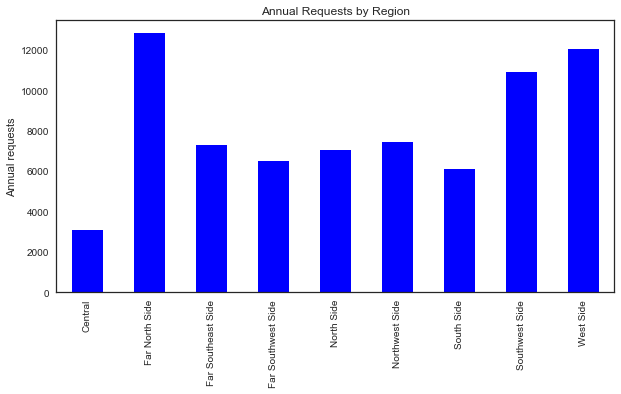

In [267]:
avgPotholeNumByRegion = totalDF.groupby('CA Region')['clean Creation Date'].count() / 6.5

fig = plt.figure(figsize=(10,5))
avgPotholeNumByRegion.plot(kind = 'bar', color = 'b')
plt.ylabel('Annual requests');
plt.xlabel('')
plt.title('Annual Requests by Region');

#### Number of potholes per block by CA

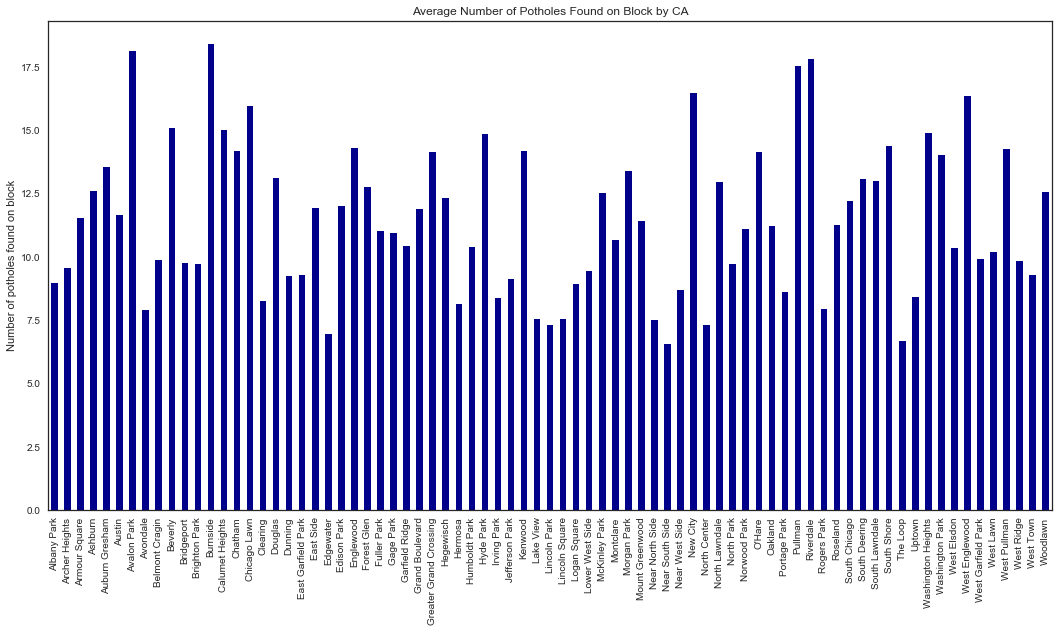

In [268]:
fig = plt.figure(figsize=(18, 9))
avgPotholeNumByCA.plot(kind = 'bar', color = 'darkblue')
plt.ylabel('Number of potholes found on block');
plt.xlabel('')
plt.title('Average Number of Potholes Found on Block by CA');

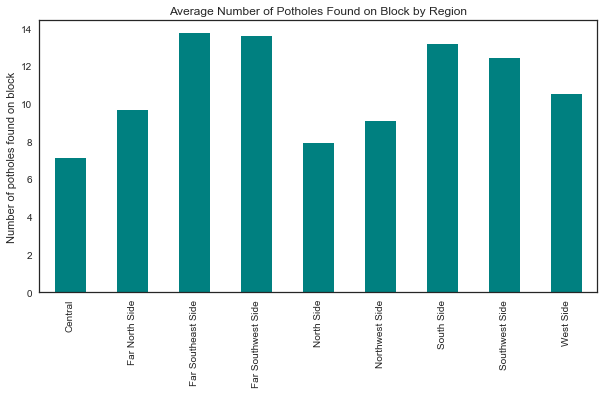

In [269]:
avgPotholeNumByRegion = totalDF.groupby('CA Region')['Num_Holes_Found'].mean()

fig = plt.figure(figsize=(10,5))
avgPotholeNumByRegion.plot(kind = 'bar', color = 'teal')
plt.ylabel('Number of potholes found on block');
plt.xlabel('')
plt.title('Average Number of Potholes Found on Block by Region');

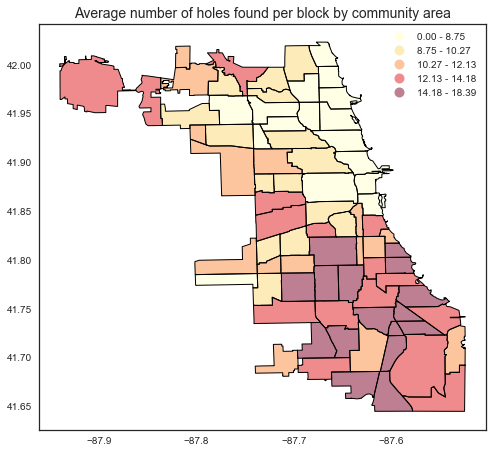

In [270]:
#Some tweaking of avgPotholeNumByCA series before merging
avgHoles_geo = avgPotholeNumByCA.copy()
avgHoles_geo.index = avgHoles_geo.index.str.upper()
avgHoles_geo.index.name = 'community'
holes_geo = avgHoles_geo.to_frame().reset_index().set_value(54, 'community', 'OHARE')
holes_geo = holes_geo.set_value(65, 'community', 'LOOP')

hole_map = pd.merge(sf,holes_geo,on='community')
ax = hole_map.plot(column='Num_Holes_Found', scheme='quantiles', k=5, cmap='YlOrRd', legend=True, figsize=(8,10));
ax.set_title('Average number of holes found per block by community area', fontsize = 14);

In [271]:
print('Northern avg number of holes found: {:.2f} \nSouthern avg number of holes found: {:.2f}'.format(north['Num_Holes_Found'].mean(), south['Num_Holes_Found'].mean()))

Northern avg number of holes found: 9.05 
Southern avg number of holes found: 13.11


In [272]:
print('Northern std number of holes found: {:.2f} \nSouthern std number of holes found: {:.2f}'.format(north['Num_Holes_Found'].std(), south['Num_Holes_Found'].std()))

Northern std number of holes found: 14.37 
Southern std number of holes found: 21.15


In [273]:
stats.ttest_ind(north['Num_Holes_Found'].dropna(), south['Num_Holes_Found'].dropna(), equal_var = False)

Ttest_indResult(statistic=-59.052420447411563, pvalue=0.0)

From the above two-tailed t-test, we see that we can reject the null hypothesis that the difference in mean number of potholes found on block between northern areas and southern areas is zero.  If converting to a two-tailed test, we can conclude that southern areas have a larger number of potholes found per block the northern ones based on the negative t-statistic.

## Linear regression analysis

In [274]:
#Create dataframe including the average pothole number by CA and the average response time by CA
m1 = pd.merge(censusDF, avgPotholeNumByCA.to_frame().reset_index(), on='GEOG')
m2 = pd.merge(m1, CA_response.to_frame().reset_index(), on = 'GEOG')

In [275]:
#Create a new dataframe to include selected features
X = m2.filter(['MEDINC', 'MED_AGE', 'Num_Holes_Found', 'TOT_POP', 'Sfperc', 'Mfperc', 'COMMperc', 'INSTperc', 'INDperc', 'TRANSperc', 'VACperc', 'timePassed'], axis = 1)
X = X.dropna()
def make_perc(column, divisor):
    return m2[column] *100 / m2[divisor]

X = X.assign(HISPperc = make_perc('HISP', 'TOT_POP'), WHITEperc = make_perc('WHITE', 'TOT_POP'), BLACKperc = make_perc('BLACK', 'TOT_POP'), ASIANperc = make_perc('ASIAN', 'TOT_POP'))
X = X.assign(OWNperc = make_perc('OWN_OCC_HU', 'TOT_HH'), DROVE_ALperc = make_perc('DROVE_AL', 'TOT_COMM'), CARPOOLperc = make_perc('CARPOOL', 'TOT_COMM'), TRANSITperc = make_perc('TRANSIT', 'TOT_COMM'), WALK_BIKEperc = make_perc('WALK_BIKE', 'TOT_COMM')) 

In [276]:
#Set up dependent variable vectors for response time and number of holes predictions
response_time = X.timePassed.copy()
holes = X.Num_Holes_Found.copy()
X.drop(['Num_Holes_Found', 'timePassed'], axis = 1, inplace = True)

In [277]:
#Let's look at how correlated our features are before starting a linear regression
X.corr()

,MEDINC,MED_AGE,TOT_POP,Sfperc,Mfperc,COMMperc,INSTperc,INDperc,TRANSperc,VACperc,ASIANperc,BLACKperc,HISPperc,WHITEperc,CARPOOLperc,DROVE_ALperc,OWNperc,TRANSITperc,WALK_BIKEperc
MEDINC,1.000000,0.298891,0.216225,0.340621,-0.117302,0.355335,0.132066,-0.273142,-0.219805,-0.523865,0.115192,-0.586838,-0.053294,0.849240,-0.268996,0.159648,0.566683,-0.279763,0.267688
MED_AGE,0.298891,1.000000,-0.264779,0.541660,-0.358874,-0.067879,0.037072,-0.280061,0.006526,-0.210683,0.128742,0.060973,-0.373472,0.242532,-0.159042,0.452832,0.587176,-0.276550,-0.257375
TOT_POP,0.216225,-0.264779,1.000000,-0.067279,0.558340,0.251192,0.032711,-0.096231,-0.201380,-0.301790,-0.006439,-0.281964,0.168822,0.227553,0.002106,-0.299652,-0.172481,0.198747,0.198562
Sfperc,0.340621,0.541660,-0.067279,1.000000,-0.444288,-0.217709,-0.064902,-0.282168,-0.253973,-0.395742,-0.211727,-0.100907,0.071994,0.160807,0.085685,0.717421,0.787626,-0.547434,-0.462131
Mfperc,-0.117302,-0.358874,0.558340,-0.444288,1.000000,0.147741,0.115363,-0.133693,-0.324793,-0.055916,0.157608,-0.087802,-0.017278,0.069571,-0.148629,-0.607794,-0.649985,0.634367,0.193893
COMMperc,0.355335,-0.067879,0.251192,-0.217709,0.147741,1.000000,-0.071619,-0.094563,-0.076912,-0.205535,0.431998,-0.262380,-0.020626,0.229437,-0.049589,-0.402018,-0.094424,0.075532,0.537736
INSTperc,0.132066,0.037072,0.032711,-0.064902,0.115363,-0.071619,1.000000,-0.189492,-0.460176,-0.092221,0.088185,-0.004079,-0.243429,0.215054,-0.251525,-0.075775,-0.078425,0.062994,0.197403
INDperc,-0.273142,-0.280061,-0.096231,-0.282168,-0.133693,-0.094563,-0.189492,1.000000,0.183648,0.045964,-0.127954,-0.074865,0.465233,-0.303193,0.423127,-0.035357,-0.082414,-0.073840,-0.070045
TRANSperc,-0.219805,0.006526,-0.201380,-0.253973,-0.324793,-0.076912,-0.460176,0.183648,1.000000,0.129960,0.053043,0.031981,0.079143,-0.143470,0.158895,0.095519,-0.018041,-0.172431,-0.022137
VACperc,-0.523865,-0.210683,-0.301790,-0.395742,-0.055916,-0.205535,-0.092221,0.045964,0.129960,1.000000,-0.230903,0.597245,-0.226962,-0.538270,-0.073411,-0.142138,-0.358702,0.273373,-0.101957


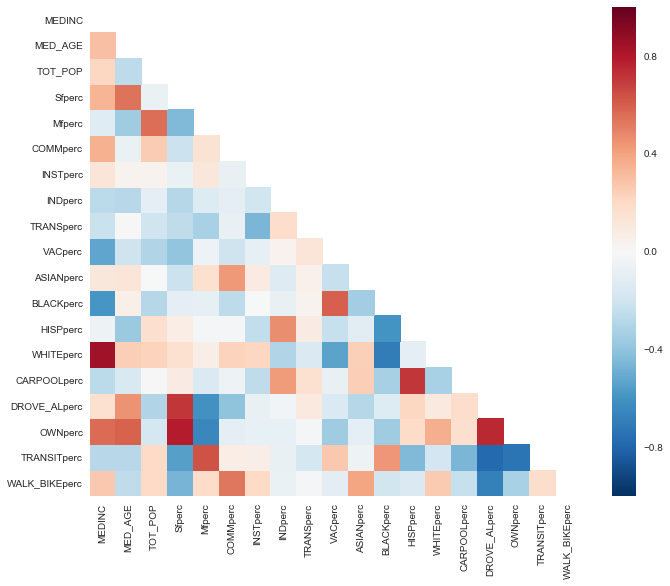

In [278]:
fig = plt.figure(figsize = (11,9))
mask = np.zeros_like(X.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(X.corr(), mask = mask);

We can see that there are several highly correlated pairs of features.  For example, the percentage of white residents is highly correlated postively with median income while the percentage of black residents is negatively correlated.  Additionally, the percentage of single-family homes is correlated with the percentage of owned property, which makes sense as the majority of single family homes are lived in by the homeowner.  Furthermore, we see that Hispanics are highly correlated with carpooling and that those who own their home are correlated with driving alone to work.

I choose to keep all these features as the correlation is not so high as to skew the regression results.

In [307]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Need to normalize due to wide variance between features (i.e. percentages between 0-100 but median income ~50,000)
lm_response = LinearRegression(normalize = True)

#Split between training and test data (0.7:0.3 ratio)
xtrain1, xtest1, ytrain1, ytest1 = train_test_split(X, response_time, test_size = 0.3, random_state = 10)

#Fit on training data
lm_response.fit(xtrain1, ytrain1)

#Look at coefficients of the model
pd.DataFrame(lm_response.coef_, index = X.columns, columns = ['estimatedCoefficients'])

,estimatedCoefficients
MEDINC,0.000050
MED_AGE,0.007166
TOT_POP,0.000105
Sfperc,0.147178
Mfperc,-0.074710
COMMperc,0.268194
INSTperc,0.247453
INDperc,0.047953
TRANSperc,0.093991
VACperc,-0.036332


In [308]:
print('MSE for training response data: {:.2f}'.format(np.mean((lm_response.predict(xtrain1) - ytrain1) **2)))
print('MSE for test response data: {:.2f}'.format(np.mean((lm_response.predict(xtest1) - ytest1) ** 2)))

MSE for training response data: 30.15
MSE for test response data: 74.38


This model is overfit.

In [309]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
m = ols('response_time ~ MEDINC + MED_AGE + TOT_POP + Sfperc + Mfperc + COMMperc + INSTperc + INDperc + TRANSperc + VACperc + HISPperc + WHITEperc + BLACKperc + ASIANperc + OWNperc + DROVE_ALperc + CARPOOLperc + TRANSITperc + WALK_BIKEperc', X).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          response_time   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     3.346
Date:                Tue, 11 Jul 2017   Prob (F-statistic):           0.000217
Time:                        14:25:03   Log-Likelihood:                -248.23
No. Observations:                  77   AIC:                             536.5
Df Residuals:                      57   BIC:                             583.3
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       119.9512    188.091      0.638      0.526      -256.695   496.597
MEDINC        -1.846e-05      0.000     -0.147      0.884        -0.000     0.000
MED_AGE           0.0633      0.326      0.194      0.847        -0.590     0.716
TOT_POP        8.253e-05   5.49e-05      1.504      0.138     -2.73e-05     0.000
Sfperc           -0.0238      0.187     -0.127      0.899        -0.399     0.352
Mfperc            0.1186      0.267      0.445      0.658        -0.415     0.652
COMMperc          0.2050      0.321      0.638      0.526        -0.439     0.849
INSTperc         -0.1423      0.211     -0.674      0.503        -0.565     0.281
INDperc          -0.0357      0.192     -0.186      0.853        -0.420     0.348
TRANSperc        -0.0486      0.161     -0.301      0.764        -0.371     0.274
VACperc          -0.2442      0.256     -0.953      0.345        -0.758     0.269
HISPperc          1.2359      1.607      0.769      0.445        -1.982     4.454
WHITEperc         1.3030      1.627      0.801      0.427        -1.956     4.562
BLACKperc         1.1899      1.609      0.740      0.462        -2.031     4.411
ASIANperc         1.2086      1.658      0.729      0.469        -2.112     4.529
OWNperc          -0.2371      0.159     -1.488      0.142        -0.556     0.082
DROVE_ALperc     -1.9472      0.921     -2.115      0.039        -3.790    -0.104
CARPOOLperc      -2.4465      0.932     -2.624      0.011        -4.313    -0.580
TRANSITperc      -2.1096      0.866     -2.435      0.018        -3.844    -0.375
WALK_BIKEperc    -2.5259      0.945     -2.672      0.010        -4.419    -0.633
==============================================================================
Omnibus:                        3.809   Durbin-Watson:                   1.656
Prob(Omnibus):                  0.149   Jarque-Bera (JB):                3.063
Skew:                           0.362   Prob(JB):                        0.216
Kurtosis:                       3.656   Cond. No.                     1.47e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [311]:
#Run linear regression on the number of holes per block found
lm_holes = LinearRegression(normalize = True)

#Split between training and test data (0.7:0.3 ratio)
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(X, holes, test_size = 0.3, random_state = 10)

#Fit on training data
lm_holes.fit(xtrain2, ytrain2)

#Look at coefficients of the model
pd.DataFrame(lm_holes.coef_, index = X.columns, columns = ['estimatedCoefficients'])

,estimatedCoefficients
MEDINC,-1.792693e-05
MED_AGE,-4.769125e-02
TOT_POP,4.848508e-07
Sfperc,-1.621029e-02
Mfperc,-1.863294e-01
COMMperc,-2.024012e-01
INSTperc,-1.227932e-01
INDperc,5.451242e-02
TRANSperc,-9.369784e-02
VACperc,-9.908408e-02


In [312]:
print('MSE for training holes data: {:.2f}'.format(np.mean((lm_holes.predict(xtrain2) - ytrain2) **2)))
print('MSE for test holes data: {:.2f}'.format(np.mean((lm_holes.predict(xtest2) - ytest2) ** 2)))

MSE for training holes data: 1.87
MSE for test holes data: 4.87


In [313]:
m = ols('holes ~ MEDINC + MED_AGE + TOT_POP + Sfperc + Mfperc + COMMperc + INSTperc + INDperc + TRANSperc + VACperc + HISPperc + WHITEperc + BLACKperc + ASIANperc + OWNperc + DROVE_ALperc + CARPOOLperc + TRANSITperc + WALK_BIKEperc', X).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  holes   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     8.363
Date:                Tue, 11 Jul 2017   Prob (F-statistic):           1.91e-10
Time:                        14:25:17   Log-Likelihood:                -140.96
No. Observations:                  77   AIC:                             321.9
Df Residuals:                      57   BIC:                             368.8
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        76.7025     46.702      1.642      0.106       -16.817   170.222
MEDINC        -2.212e-05   3.12e-05     -0.709      0.481     -8.46e-05  4.04e-05
MED_AGE          -0.0460      0.081     -0.568      0.572        -0.208     0.116
TOT_POP        -5.47e-07   1.36e-05     -0.040      0.968     -2.78e-05  2.67e-05
Sfperc            0.0044      0.047      0.095      0.924        -0.089     0.098
Mfperc           -0.1662      0.066     -2.512      0.015        -0.299    -0.034
COMMperc         -0.1625      0.080     -2.037      0.046        -0.322    -0.003
INSTperc         -0.0680      0.052     -1.297      0.200        -0.173     0.037
INDperc           0.0744      0.048      1.563      0.124        -0.021     0.170
TRANSperc        -0.0580      0.040     -1.450      0.152        -0.138     0.022
VACperc          -0.0748      0.064     -1.176      0.245        -0.202     0.053
HISPperc         -0.8768      0.399     -2.197      0.032        -1.676    -0.078
WHITEperc        -0.8488      0.404     -2.101      0.040        -1.658    -0.040
BLACKperc        -0.8069      0.399     -2.020      0.048        -1.607    -0.007
ASIANperc        -0.8799      0.412     -2.137      0.037        -1.704    -0.055
OWNperc          -0.0056      0.040     -0.141      0.888        -0.085     0.074
DROVE_ALperc      0.2525      0.229      1.105      0.274        -0.205     0.710
CARPOOLperc       0.4150      0.231      1.793      0.078        -0.049     0.879
TRANSITperc       0.2233      0.215      1.038      0.304        -0.207     0.654
WALK_BIKEperc     0.2777      0.235      1.183      0.242        -0.192     0.748
==============================================================================
Omnibus:                        1.512   Durbin-Watson:                   2.400
Prob(Omnibus):                  0.469   Jarque-Bera (JB):                1.285
Skew:                          -0.140   Prob(JB):                        0.526
Kurtosis:                       2.433   Cond. No.                     1.47e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

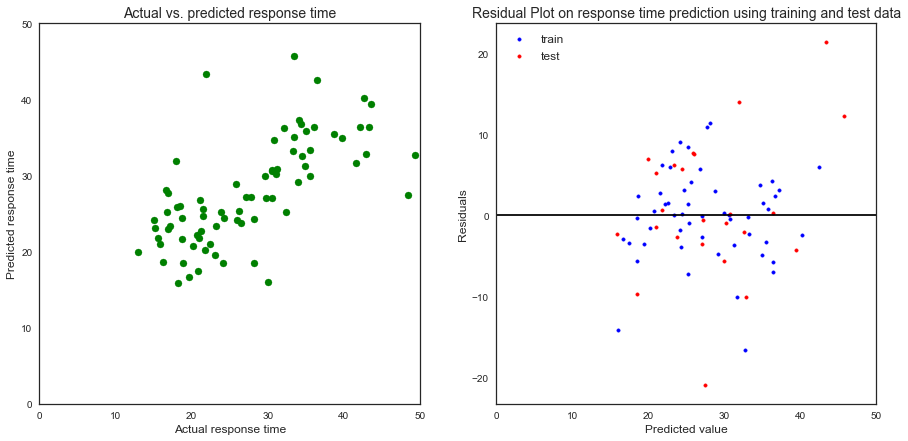

In [314]:
fig = plt.figure(figsize=(15, 7))

#Plot actual vs. predicted on response time
plt.subplot(1,2,1)
plt.scatter(response_time, lm_response.predict(X), c='g');
plt.xlim([0,50]);
plt.ylim([0,50]);
plt.xlabel('Actual response time', fontsize = 12);
plt.ylabel('Predicted response time', fontsize = 12);
plt.title('Actual vs. predicted response time', fontsize = 14);

#Plot residuals of response time prediction
plt.subplot(1,2,2)
plt.scatter(lm_response.predict(xtrain1), lm_response.predict(xtrain1) - ytrain1, c='b', marker = '.', label = 'train')
plt.scatter(lm_response.predict(xtest1), lm_response.predict(xtest1) - ytest1, c='r', marker = '.', label = 'test')
plt.hlines(y = 0, xmin=-50, xmax = 50)
plt.title('Residual Plot on response time prediction using training and test data',  fontsize = 14);
plt.ylabel('Residuals', fontsize = 12);
plt.xlabel('Predicted value', fontsize = 12);
plt.xlim([0,50]);
plt.legend(fontsize = 12, loc = 2)

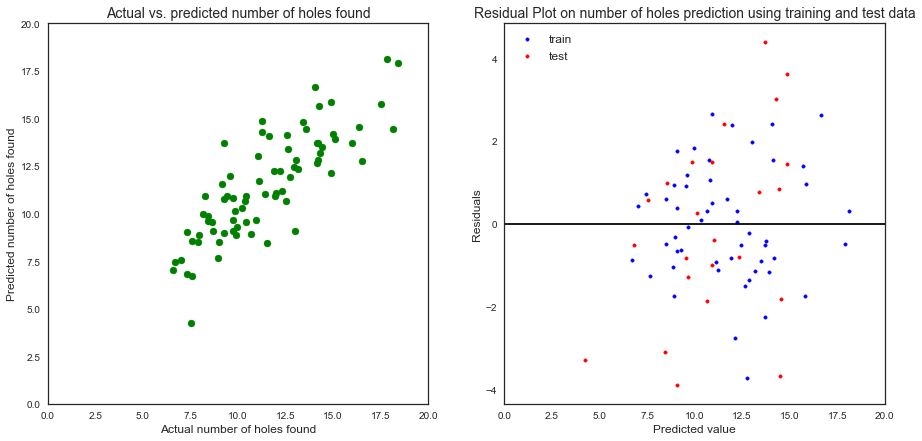

In [315]:
fig = plt.figure(figsize=(15,7))

#Plot actual vs. predicted on number of holes found
plt.subplot(1,2,1)
plt.scatter(holes, lm_holes.predict(X), c='g');
plt.xlim([0,20])
plt.ylim([0,20])
plt.xlabel('Actual number of holes found', fontsize = 12);
plt.ylabel('Predicted number of holes found', fontsize = 12);
plt.title('Actual vs. predicted number of holes found', fontsize = 14);

#Plot residuals of number of holes prediction
plt.subplot(1,2,2)
plt.scatter(lm_holes.predict(xtrain2), lm_holes.predict(xtrain2) - ytrain2, c='b', marker = '.', label = 'train')
plt.scatter(lm_holes.predict(xtest2), lm_holes.predict(xtest2) - ytest2, c='r', marker = '.', label = 'test')
plt.hlines(y = 0, xmin=-20, xmax = 20)
plt.title('Residual Plot on number of holes prediction using training and test data', fontsize = 14);
plt.ylabel('Residuals', fontsize = 12);
plt.xlabel('Predicted value', fontsize = 12);
plt.xlim([0,20]);
plt.legend(fontsize = 12, loc = 2)

In [316]:
#Using K-folds and cross-validation
from sklearn.model_selection import cross_val_score, KFold
kf = KFold(5, shuffle = True)
lm_response_cv = LinearRegression(normalize = True)

#Find MSE on response time prediction
scores = cross_val_score(lm_response_cv, X, response_time, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {:.2f} \nSE: {:.2f}'.format(np.mean(np.abs(scores)), scores.std()))

MSE: 68.98 
SE: 21.64


In [317]:
#Find MSE on number of holes prediction
lm_holes_cv = LinearRegression(normalize = True)
scores = cross_val_score(lm_holes_cv, X, holes, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {:.2f} \nSE: {:.2f}'.format(np.mean(np.abs(scores)), scores.std()))

MSE: 5.72 
SE: 2.23


# Random forest regression

In [318]:
from sklearn.ensemble import RandomForestRegressor

rf_response = RandomForestRegressor(random_state = 10)
rf_holes = RandomForestRegressor(random_state = 10)

rf_response.fit(xtrain1, ytrain1)
rf_holes.fit(xtrain2, ytrain2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=10,
           verbose=0, warm_start=False)

In [319]:
response_score = rf_response.score(xtrain1, ytrain1)
hole_score = rf_holes.score(xtrain2, ytrain2)

print('Training R2 on response Random Forest prediction {} \nTraining R2 on number of holes Random Forest prediction {}'.format(response_score, hole_score))

Training R2 on response Random Forest prediction 0.8898273094431572 
Training R2 on number of holes Random Forest prediction 0.899609697657878


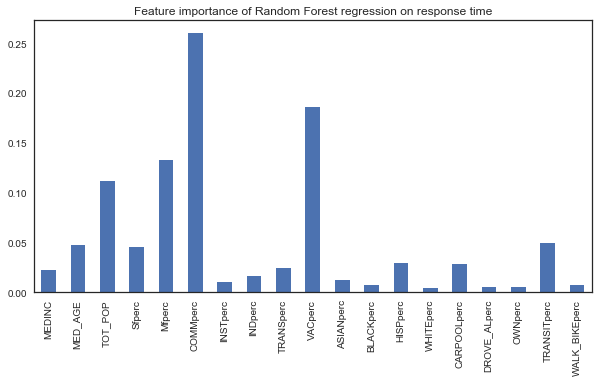

In [320]:
response_features = pd.Series(rf_response.feature_importances_, index = X.columns)
fig = plt.figure(figsize=(10,5));
response_features.plot(kind = 'bar');
plt.title('Feature importance of Random Forest regression on response time');

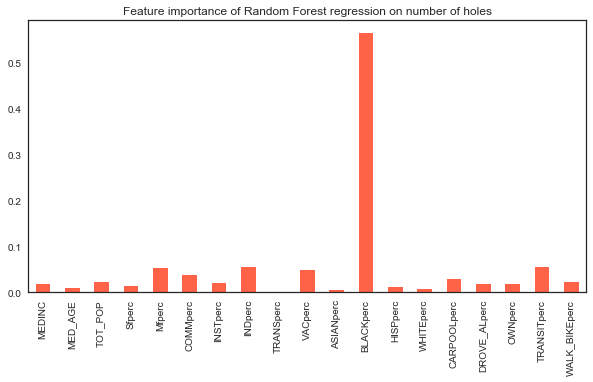

In [321]:
holes_features = pd.Series(rf_holes.feature_importances_, index = X.columns)
fig = plt.figure(figsize=(10,5));
holes_features.plot(kind = 'bar', color = 'tomato');
plt.title('Feature importance of Random Forest regression on number of holes');

In [322]:
#Find MSE on response time prediction using 5 K-folds
kf = KFold(5, shuffle = True)
scores = cross_val_score(rf_response, X, response_time, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {} \nSE: {}'.format(np.mean(np.abs(scores)), scores.std()))

MSE: 82.17653339014323 
SE: 18.32680285062767


In [323]:
#Find MSE on number of holes prediction using 5 K-folds 
scores = cross_val_score(rf_holes, X, holes, scoring = 'neg_mean_squared_error', cv = kf)
print('MSE: {} \nSE: {}'.format(np.mean(np.abs(scores)), scores.std()))

MSE: 4.997374519403246 
SE: 2.2380103144221404


In [324]:
print('MSE for training response data: {:.2f}'.format(np.mean((rf_response.predict(xtrain1) - ytrain1) **2)))
print('MSE for test response data: {:.2f}'.format(np.mean((rf_response.predict(xtest1) - ytest1) ** 2)))

MSE for training response data: 8.01
MSE for test response data: 84.07


In [325]:
print('MSE for training holes data: {:.2f}'.format(np.mean((rf_holes.predict(xtrain2) - ytrain2) **2)))
print('MSE for test holes data: {:.2f}'.format(np.mean((rf_holes.predict(xtest2) - ytest2) ** 2)))

MSE for training holes data: 0.91
MSE for test holes data: 4.19


# PCA & Clustering

Let's now visualize the census data in two dimensions using PCA to look into clustering possibilities.  Can we cluster based on region as originally theorized?

In [326]:
train_clust = pd.concat([xtrain1, ytrain1], axis = 1)
test_clust = pd.concat([xtest1, ytest1], axis = 1)
clust_set = pd.concat([train_clust, test_clust], axis = 0)

CA_table = pd.merge(m2, CA_key, on='GEOG')
train_CA = CA_table.loc[list(train_clust.index)]
test_CA = CA_table.loc[list(test_clust.index)]

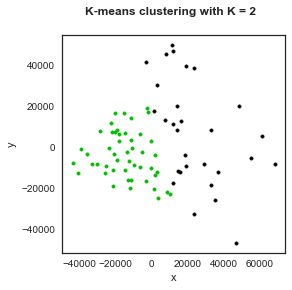

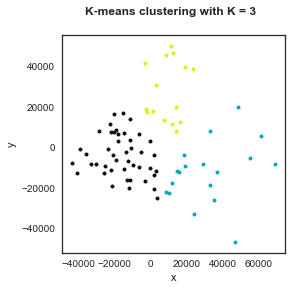

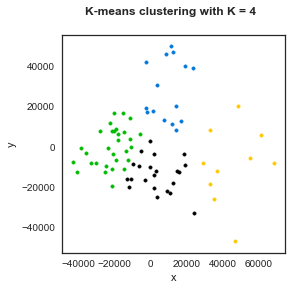

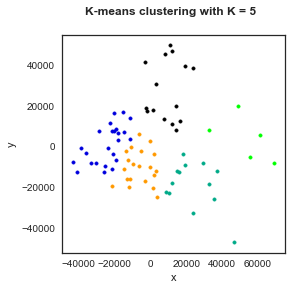

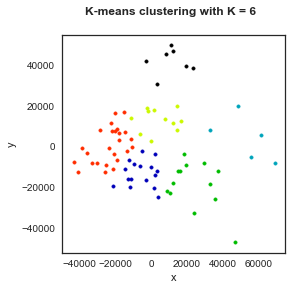

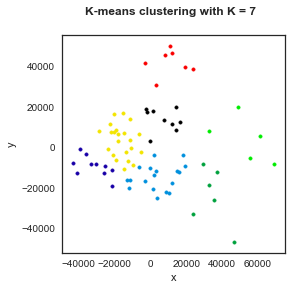

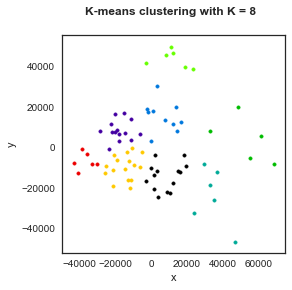

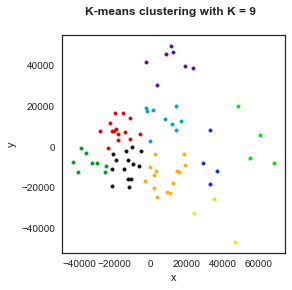

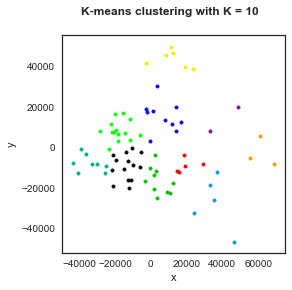

In [336]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.cm as cm

#First we'll iterate through 2-10 clusters to visualize the clustering.
pca = PCA(n_components = 2)
x = pca.fit_transform(clust_set)[:,0]
y = pca.fit_transform(clust_set)[:,1]

for K in range(2,11):
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(4,4)
    kmeans = KMeans(n_clusters = K, random_state = 10).fit_predict(clust_set)
    df = pd.DataFrame({'cluster_id':kmeans, 'x':x, 'y':y})
    for i in range(K):
        color = cm.spectral(float(i) / K)
        clustered_data = df[df.cluster_id == i]
        ax1.scatter(clustered_data.x, clustered_data.y, color = color, marker = '.')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    plt.suptitle(('K-means clustering with K = %d' %K), fontsize = 12, fontweight = 'bold')
    plt.show()

Visually, 4-6 clusters make the most sense.  Let's try some computational methods of determining the optimal K.

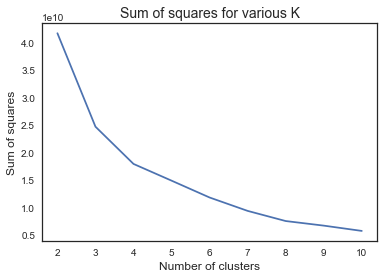

In [328]:
#Try elbow method to determine optimal number of clusters
SS = []
for K in range(2, 11):
    kmeans = KMeans(n_clusters = K).fit(clust_set) #Using all default values from method
    SS.append(kmeans.inertia_)
    
plt.plot(range(2,11), SS);
plt.xlabel('Number of clusters', fontsize = 12);
plt.ylabel('Sum of squares', fontsize = 12);
plt.title('Sum of squares for various K', fontsize = 14);

Elbows appears to be around 4 clusters.

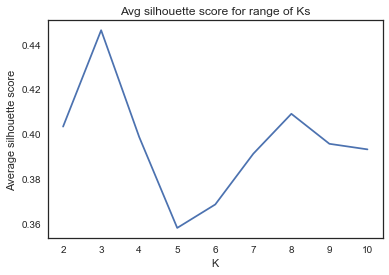

In [329]:
#Plot average silhouette score for range of K's
score = []
from sklearn.metrics import silhouette_score, silhouette_samples
for K in range(2,11):
    clusterer = KMeans(n_clusters = K, random_state = 10)
    cluster_labels = clusterer.fit_predict(clust_set)
    score.append(silhouette_score(clust_set, cluster_labels))
    
plt.plot(range(2,11), score);
plt.xlabel('K');
plt.ylabel('Average silhouette score');
plt.title('Avg silhouette score for range of Ks');

The graph above shows that 3 clusters has a peak in silhouette score of around 0.45, which is still considered a weak structure.  Let's dig into the original data to see how K = 3 split up the community areas.

In [330]:
kmeans = KMeans(n_clusters = 3, random_state = 10).fit_predict(clust_set)
new_df = pd.DataFrame({'CA_name': CA_table.GEOG, 'CA_region': CA_table['CA Region'], 'cluster_id':kmeans})
total_df = new_df.sort_values(by = 'cluster_id')
total_df.groupby(['cluster_id', 'CA_region'])['CA_region'].count()

cluster_id  CA_region         
0           Far North Side        8
            Far Southeast Side    6
            Far Southwest Side    4
            North Side            4
            Northwest Side        3
            South Side            5
            Southwest Side        8
            West Side             6
1           Central               3
            Far North Side        1
            Far Southeast Side    5
            Far Southwest Side    1
            Northwest Side        2
            South Side            3
            Southwest Side        1
            West Side             2
2           Far North Side        3
            Far Southeast Side    1
            Far Southwest Side    1
            North Side            1
            Northwest Side        1
            South Side            4
            Southwest Side        3
            West Side             1
Name: CA_region, dtype: int64

These results seem to be scattered geographically.

In [331]:
kmeans = KMeans(n_clusters = 9, random_state = 10).fit_predict(clust_set)
new_df = pd.DataFrame({'CA_name': CA_table.GEOG, 'CA_region': CA_table['CA Region'], 'cluster_id':kmeans})
total_df = new_df.sort_values(by = 'cluster_id')
total_df.groupby(['cluster_id', 'CA_region'])['CA_region'].count()

cluster_id  CA_region         
0           Far Southeast Side    2
            Far Southwest Side    1
            Northwest Side        3
            South Side            2
            Southwest Side        3
            West Side             3
1           Far North Side        1
            Far Southwest Side    1
            North Side            1
            South Side            2
            Southwest Side        2
2           Central               1
            Far Southeast Side    1
            Far Southwest Side    1
            Southwest Side        1
3           Far North Side        2
            Far Southeast Side    1
            Northwest Side        1
            South Side            2
            Southwest Side        2
            West Side             1
4           Far North Side        1
            Far Southeast Side    1
            North Side            2
            South Side            3
            West Side             1
5           Far Southeast Side   

The clusters are scattered variously among the regions. Let's look at K=4, which was the optimal using the elbow method.

In [332]:
kmeans = KMeans(n_clusters = 4, random_state = 10).fit_predict(clust_set)
new_df = pd.DataFrame({'CA_name': CA_table.GEOG, 'CA_region': CA_table['CA Region'], 'cluster_id':kmeans})
total_df = new_df.sort_values(by = 'cluster_id')
total_df.groupby(['cluster_id', 'CA_region'])['CA_region'].count()

cluster_id  CA_region         
0           Central               1
            Far North Side        3
            Far Southeast Side    3
            Far Southwest Side    1
            North Side            1
            Northwest Side        3
            South Side            4
            Southwest Side        4
            West Side             2
1           Far North Side        3
            Far Southeast Side    1
            Far Southwest Side    1
            North Side            1
            Northwest Side        1
            South Side            4
            Southwest Side        3
            West Side             1
2           Far North Side        6
            Far Southeast Side    5
            Far Southwest Side    3
            North Side            3
            Northwest Side        1
            South Side            3
            Southwest Side        4
            West Side             5
3           Central               2
            Far Southeast Side   

Again, cluster 1 is weighted toward the southern regions, while cluster 2 contains most of the western CA's. 

In [333]:
#Finally we look at K=2 to test the north-south divide
kmeans = KMeans(n_clusters = 2, random_state = 10).fit(train_clust)
clusters = kmeans.predict(train_clust)
new_df = pd.DataFrame({'CA_name': train_CA.GEOG, 'CA_region': train_CA['CA Region'], 'cluster_id':clusters})
total_df = new_df.sort_values(by = 'cluster_id')
total_df.groupby(['cluster_id', 'CA_region'])['CA_region'].count()

cluster_id  CA_region         
0           Central               2
            Far North Side        6
            Far Southwest Side    1
            North Side            3
            Northwest Side        3
            Southwest Side        1
            West Side             3
1           Far North Side        2
            Far Southeast Side    9
            Far Southwest Side    1
            North Side            1
            Northwest Side        2
            South Side            9
            Southwest Side        8
            West Side             2
Name: CA_region, dtype: int64

Cluster 0 contains 12 northern CA's and 2 southern ones, while cluster 1 contains 5 northern CA's and 27 southern ones. While not a perfect clustering, let's see how this generalizes to the test data.

In [334]:
new_clusters = kmeans.predict(test_clust)
new_df = pd.DataFrame({'CA_name': test_CA.GEOG, 'CA_region': test_CA['CA Region'], 'cluster_id':new_clusters})
total_df = new_df.sort_values(by = 'cluster_id')
total_df.groupby(['cluster_id', 'CA_region'])['CA_region'].count()

cluster_id  CA_region         
0           Central               1
            Far North Side        4
            Far Southwest Side    2
            North Side            1
            Northwest Side        1
            West Side             1
1           Far Southeast Side    3
            Far Southwest Side    2
            South Side            3
            Southwest Side        3
            West Side             3
Name: CA_region, dtype: int64

Cluster 0 has 6 northern CA's and 2 southern ones, while cluster 1 has 0 northern CA's and 11 southern ones.  We can say this clustering predicted fairly accurately on the test data for southern and northern CA's, although it might be more instructive to run this clustering on a larger dataset--perhaps census tracts--to have more samples in the test data. 